# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

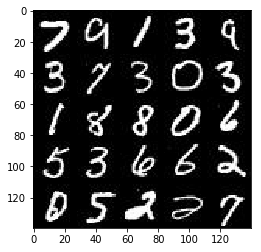

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

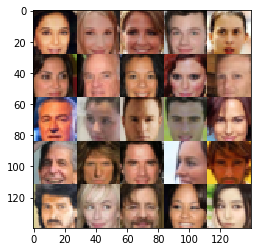

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator",reuse=reuse):
        alpha=0.2

        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        l1 = tf.maximum(l1 * alpha, l1)

        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2,training=True)
        l2 = tf.maximum(l2 * alpha, l2)
        
        l3 = tf.layers.conv2d(l2, 256, 5, strides=1, padding='same')
        l3 = tf.layers.batch_normalization(l2,training=True)
        l3 = tf.maximum(l3 * alpha, l2)
        
        flat = tf.reshape(l2, (-1,7*7*256))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now

        # 28x28x(out_channel_dimension) now
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        return tf.tanh(logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # get counterfit from generator, 
    # get output from discriminator using real input
    # get output from discriminator using counterfit generated
    g_out = generator(input_z,out_channel_dim=out_channel_dim)
    d_real_out, d_real_logit = discriminator(input_real)
    d_fake_out, d_fake_logit = discriminator(g_out,reuse=True)
    
    #real label smoothing
    smooth = 0.1
    
    # shortcut loss calculation function
    calculate_loss = lambda logits,labels : tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
    
    d_loss_real = calculate_loss(d_real_logit, tf.ones_like(d_real_out) * (1 - smooth))
    d_loss_fake = calculate_loss(d_fake_logit, tf.zeros_like(d_fake_out))
    
    g_loss = calculate_loss(d_fake_logit, tf.ones_like(d_fake_out))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # get variables for `var_list` minimize parameter
    trainables = tf.trainable_variables()

    # filter those by generator/discriminator
    gen_train = [operation for operation in trainables if operation.name.startswith('generator')]
    dis_train = [operation for operation in trainables if operation.name.startswith('discriminator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # use with control dependencies for batch normalization calculations updating
    with tf.control_dependencies(g_update_ops):
        # calculate optimizations
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=gen_train)

    # use with control dependencies for batch normalization calculations updating
    with tf.control_dependencies(d_update_ops):
        # calculate optimizations
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=dis_train)
        
    return g_train_opt, d_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_input, z_input, lr = model_inputs(data_shape[1],
                                           data_shape[2], 
                                           data_shape[3], 
                                           z_dim)
    
    d_loss, g_loss = model_loss(real_input, 
                                z_input, 
                                data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss,
                             g_loss,
                             learning_rate,
                             beta1)
    
    steps, step_text_update, step_example_update = 0, 10, 100
    sample_size = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                # resize b/c we used -.5 to .5 instead of -1 to 1
                batch_images = batch_images * 2
                
                # random sample noise 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr: learning_rate, real_input: batch_images})
                
                if steps % step_text_update == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("epoch {}/{} ***".format(epoch_i+1, epochs),
                          "discriminator loss: {:.4f} ***".format(train_loss_d),
                          "generator loss: {:.4f}".format(train_loss_g))                    
                
                if steps % step_example_update == 0:
                    show_generator_output(sess, sample_size, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1/2 *** discriminator loss: 0.5838 *** generator loss: 3.1138
epoch 1/2 *** discriminator loss: 0.4437 *** generator loss: 3.4133
epoch 1/2 *** discriminator loss: 0.7852 *** generator loss: 3.0259
epoch 1/2 *** discriminator loss: 1.1554 *** generator loss: 2.0774
epoch 1/2 *** discriminator loss: 0.8764 *** generator loss: 2.1765
epoch 1/2 *** discriminator loss: 0.9143 *** generator loss: 1.6768
epoch 1/2 *** discriminator loss: 0.8995 *** generator loss: 2.3173
epoch 1/2 *** discriminator loss: 1.4612 *** generator loss: 1.8836
epoch 1/2 *** discriminator loss: 1.2433 *** generator loss: 0.8527
epoch 1/2 *** discriminator loss: 1.3852 *** generator loss: 1.4951


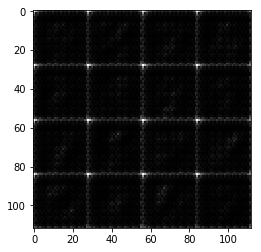

epoch 1/2 *** discriminator loss: 1.1153 *** generator loss: 1.0807
epoch 1/2 *** discriminator loss: 1.0258 *** generator loss: 1.3943
epoch 1/2 *** discriminator loss: 1.3662 *** generator loss: 0.8937
epoch 1/2 *** discriminator loss: 1.6661 *** generator loss: 0.9351
epoch 1/2 *** discriminator loss: 1.1559 *** generator loss: 1.1223
epoch 1/2 *** discriminator loss: 1.0740 *** generator loss: 1.2395
epoch 1/2 *** discriminator loss: 1.0157 *** generator loss: 1.2281
epoch 1/2 *** discriminator loss: 1.2558 *** generator loss: 1.1629
epoch 1/2 *** discriminator loss: 1.2070 *** generator loss: 1.3110
epoch 1/2 *** discriminator loss: 1.2275 *** generator loss: 0.8099


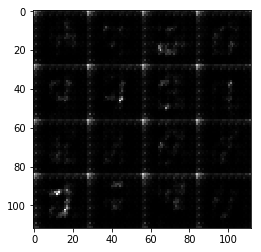

epoch 1/2 *** discriminator loss: 1.1111 *** generator loss: 1.3757
epoch 1/2 *** discriminator loss: 1.0976 *** generator loss: 0.8942
epoch 1/2 *** discriminator loss: 1.1851 *** generator loss: 1.3254
epoch 1/2 *** discriminator loss: 1.1483 *** generator loss: 0.9251
epoch 1/2 *** discriminator loss: 1.2391 *** generator loss: 1.0293
epoch 1/2 *** discriminator loss: 1.2648 *** generator loss: 0.8283
epoch 1/2 *** discriminator loss: 1.0786 *** generator loss: 1.4334
epoch 1/2 *** discriminator loss: 1.1687 *** generator loss: 1.3894
epoch 1/2 *** discriminator loss: 1.2026 *** generator loss: 1.2870
epoch 1/2 *** discriminator loss: 1.3071 *** generator loss: 1.4303


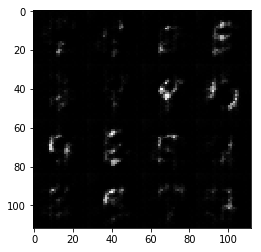

epoch 1/2 *** discriminator loss: 0.9853 *** generator loss: 1.6745
epoch 1/2 *** discriminator loss: 1.4211 *** generator loss: 1.0476
epoch 1/2 *** discriminator loss: 1.1555 *** generator loss: 1.3099
epoch 1/2 *** discriminator loss: 1.0623 *** generator loss: 1.5978
epoch 1/2 *** discriminator loss: 1.1831 *** generator loss: 1.1431
epoch 1/2 *** discriminator loss: 1.1282 *** generator loss: 0.9340
epoch 1/2 *** discriminator loss: 1.1234 *** generator loss: 1.4517
epoch 1/2 *** discriminator loss: 1.2910 *** generator loss: 0.7816
epoch 1/2 *** discriminator loss: 1.2104 *** generator loss: 0.8026
epoch 1/2 *** discriminator loss: 1.4649 *** generator loss: 0.4853


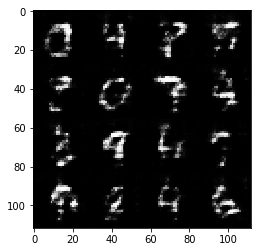

epoch 1/2 *** discriminator loss: 1.2578 *** generator loss: 1.1377
epoch 1/2 *** discriminator loss: 1.1434 *** generator loss: 0.8065
epoch 1/2 *** discriminator loss: 1.0679 *** generator loss: 1.4996
epoch 1/2 *** discriminator loss: 1.3276 *** generator loss: 1.4625
epoch 1/2 *** discriminator loss: 0.9997 *** generator loss: 1.3934
epoch 1/2 *** discriminator loss: 1.1225 *** generator loss: 1.1432
epoch 1/2 *** discriminator loss: 1.1889 *** generator loss: 1.4543
epoch 1/2 *** discriminator loss: 1.1848 *** generator loss: 0.9571
epoch 1/2 *** discriminator loss: 1.2753 *** generator loss: 1.1394
epoch 1/2 *** discriminator loss: 1.1424 *** generator loss: 1.0756


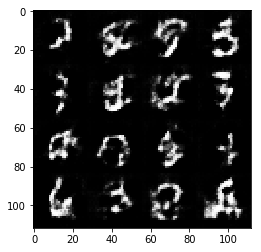

epoch 1/2 *** discriminator loss: 1.4102 *** generator loss: 0.5822
epoch 1/2 *** discriminator loss: 1.1535 *** generator loss: 0.9220
epoch 1/2 *** discriminator loss: 1.1603 *** generator loss: 1.2039
epoch 1/2 *** discriminator loss: 1.2803 *** generator loss: 0.6265
epoch 1/2 *** discriminator loss: 1.3707 *** generator loss: 0.6503
epoch 1/2 *** discriminator loss: 1.2780 *** generator loss: 1.4649
epoch 1/2 *** discriminator loss: 1.3341 *** generator loss: 0.9737
epoch 1/2 *** discriminator loss: 1.1660 *** generator loss: 0.9886
epoch 1/2 *** discriminator loss: 0.9916 *** generator loss: 1.2293
epoch 1/2 *** discriminator loss: 1.1048 *** generator loss: 1.2246


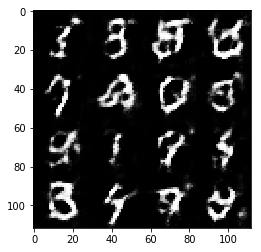

epoch 1/2 *** discriminator loss: 1.3082 *** generator loss: 1.2629
epoch 1/2 *** discriminator loss: 1.2297 *** generator loss: 1.3401
epoch 1/2 *** discriminator loss: 1.3795 *** generator loss: 1.7622
epoch 1/2 *** discriminator loss: 1.1452 *** generator loss: 1.4058
epoch 1/2 *** discriminator loss: 1.2661 *** generator loss: 0.7382
epoch 1/2 *** discriminator loss: 1.0618 *** generator loss: 1.0852
epoch 1/2 *** discriminator loss: 1.2378 *** generator loss: 0.8106
epoch 1/2 *** discriminator loss: 1.0080 *** generator loss: 1.3931
epoch 1/2 *** discriminator loss: 1.3933 *** generator loss: 0.6122
epoch 1/2 *** discriminator loss: 1.0786 *** generator loss: 1.2023


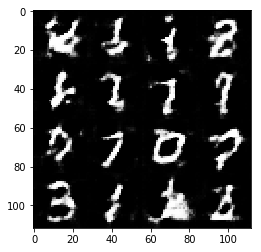

epoch 1/2 *** discriminator loss: 1.2063 *** generator loss: 0.7964
epoch 1/2 *** discriminator loss: 1.1742 *** generator loss: 1.0357
epoch 1/2 *** discriminator loss: 1.2907 *** generator loss: 0.9972
epoch 1/2 *** discriminator loss: 1.1262 *** generator loss: 0.8237
epoch 1/2 *** discriminator loss: 1.2227 *** generator loss: 0.8630
epoch 1/2 *** discriminator loss: 1.3692 *** generator loss: 0.6043
epoch 1/2 *** discriminator loss: 1.2470 *** generator loss: 0.8733
epoch 1/2 *** discriminator loss: 1.1915 *** generator loss: 1.1908
epoch 1/2 *** discriminator loss: 1.3324 *** generator loss: 0.7198
epoch 1/2 *** discriminator loss: 1.2571 *** generator loss: 0.7695


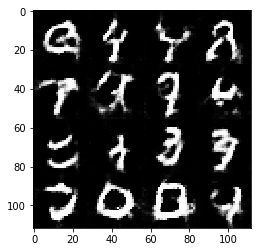

epoch 1/2 *** discriminator loss: 1.3174 *** generator loss: 1.1759
epoch 1/2 *** discriminator loss: 1.1140 *** generator loss: 1.0063
epoch 1/2 *** discriminator loss: 1.2447 *** generator loss: 0.9833
epoch 1/2 *** discriminator loss: 1.3916 *** generator loss: 0.8876
epoch 1/2 *** discriminator loss: 1.3141 *** generator loss: 1.3573
epoch 1/2 *** discriminator loss: 1.2079 *** generator loss: 1.0187
epoch 1/2 *** discriminator loss: 1.0941 *** generator loss: 1.3399
epoch 1/2 *** discriminator loss: 1.0763 *** generator loss: 0.9450
epoch 1/2 *** discriminator loss: 1.3104 *** generator loss: 0.9083
epoch 1/2 *** discriminator loss: 1.3571 *** generator loss: 1.0193


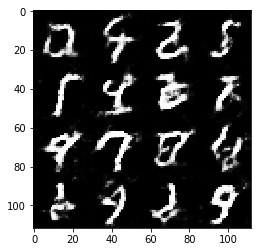

epoch 1/2 *** discriminator loss: 1.4948 *** generator loss: 0.5524
epoch 1/2 *** discriminator loss: 1.3499 *** generator loss: 0.7530
epoch 1/2 *** discriminator loss: 1.3781 *** generator loss: 0.7379
epoch 1/2 *** discriminator loss: 1.2949 *** generator loss: 1.3923
epoch 1/2 *** discriminator loss: 1.2251 *** generator loss: 1.3339
epoch 1/2 *** discriminator loss: 1.3778 *** generator loss: 0.7589
epoch 1/2 *** discriminator loss: 1.2733 *** generator loss: 1.6122
epoch 1/2 *** discriminator loss: 1.2722 *** generator loss: 0.8283
epoch 1/2 *** discriminator loss: 1.2455 *** generator loss: 0.9742
epoch 1/2 *** discriminator loss: 1.1869 *** generator loss: 0.8041


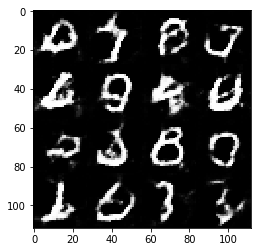

epoch 1/2 *** discriminator loss: 1.1588 *** generator loss: 1.2257
epoch 1/2 *** discriminator loss: 1.2154 *** generator loss: 0.9279
epoch 1/2 *** discriminator loss: 1.1983 *** generator loss: 0.8712
epoch 1/2 *** discriminator loss: 1.3007 *** generator loss: 1.0056
epoch 1/2 *** discriminator loss: 1.3177 *** generator loss: 0.8998
epoch 1/2 *** discriminator loss: 1.2758 *** generator loss: 0.9987
epoch 1/2 *** discriminator loss: 1.2430 *** generator loss: 0.8404
epoch 1/2 *** discriminator loss: 1.0809 *** generator loss: 1.2571
epoch 1/2 *** discriminator loss: 1.2208 *** generator loss: 0.7069
epoch 1/2 *** discriminator loss: 1.0799 *** generator loss: 1.0466


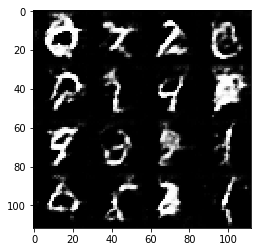

epoch 1/2 *** discriminator loss: 1.1497 *** generator loss: 1.2256
epoch 1/2 *** discriminator loss: 1.3728 *** generator loss: 0.9567
epoch 1/2 *** discriminator loss: 1.2753 *** generator loss: 0.7971
epoch 1/2 *** discriminator loss: 1.3868 *** generator loss: 1.1107
epoch 1/2 *** discriminator loss: 1.3221 *** generator loss: 1.2323
epoch 1/2 *** discriminator loss: 1.2885 *** generator loss: 1.0876
epoch 1/2 *** discriminator loss: 1.2779 *** generator loss: 1.1558
epoch 1/2 *** discriminator loss: 1.1641 *** generator loss: 1.2459
epoch 1/2 *** discriminator loss: 1.2071 *** generator loss: 0.8556
epoch 1/2 *** discriminator loss: 1.0705 *** generator loss: 1.2611


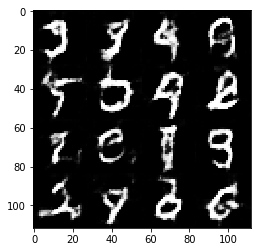

epoch 1/2 *** discriminator loss: 1.2362 *** generator loss: 0.7333
epoch 1/2 *** discriminator loss: 1.0900 *** generator loss: 1.3792
epoch 1/2 *** discriminator loss: 1.2195 *** generator loss: 0.7633
epoch 1/2 *** discriminator loss: 1.4111 *** generator loss: 1.2377
epoch 1/2 *** discriminator loss: 1.2326 *** generator loss: 1.1831
epoch 1/2 *** discriminator loss: 1.2427 *** generator loss: 0.8327
epoch 1/2 *** discriminator loss: 1.1585 *** generator loss: 1.0296
epoch 1/2 *** discriminator loss: 1.5786 *** generator loss: 0.5163
epoch 1/2 *** discriminator loss: 1.1150 *** generator loss: 0.9747
epoch 1/2 *** discriminator loss: 1.2955 *** generator loss: 1.3133


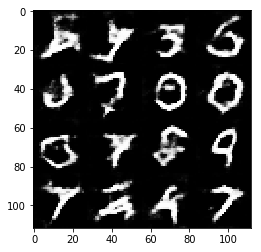

epoch 1/2 *** discriminator loss: 1.1847 *** generator loss: 1.0641
epoch 1/2 *** discriminator loss: 1.2570 *** generator loss: 1.0714
epoch 1/2 *** discriminator loss: 1.1007 *** generator loss: 1.3302
epoch 1/2 *** discriminator loss: 1.1257 *** generator loss: 0.8410
epoch 1/2 *** discriminator loss: 1.3804 *** generator loss: 0.7639
epoch 1/2 *** discriminator loss: 1.3757 *** generator loss: 0.7709
epoch 1/2 *** discriminator loss: 1.1401 *** generator loss: 1.0428
epoch 1/2 *** discriminator loss: 1.3716 *** generator loss: 1.4176
epoch 1/2 *** discriminator loss: 1.1862 *** generator loss: 0.8851
epoch 1/2 *** discriminator loss: 1.2529 *** generator loss: 0.9840


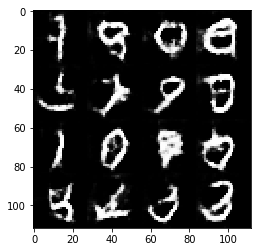

epoch 1/2 *** discriminator loss: 1.1601 *** generator loss: 0.8894
epoch 1/2 *** discriminator loss: 1.1051 *** generator loss: 1.1704
epoch 1/2 *** discriminator loss: 1.1829 *** generator loss: 1.0304
epoch 1/2 *** discriminator loss: 1.1578 *** generator loss: 1.2028
epoch 1/2 *** discriminator loss: 1.0808 *** generator loss: 1.3403
epoch 1/2 *** discriminator loss: 1.0515 *** generator loss: 1.2448
epoch 1/2 *** discriminator loss: 1.1763 *** generator loss: 0.9588
epoch 1/2 *** discriminator loss: 1.2894 *** generator loss: 0.8805
epoch 1/2 *** discriminator loss: 1.2419 *** generator loss: 0.8521
epoch 1/2 *** discriminator loss: 1.1759 *** generator loss: 1.6788


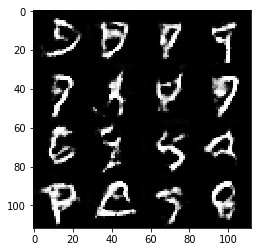

epoch 1/2 *** discriminator loss: 1.0211 *** generator loss: 1.1186
epoch 1/2 *** discriminator loss: 1.1807 *** generator loss: 1.3249
epoch 1/2 *** discriminator loss: 1.2025 *** generator loss: 1.0431
epoch 1/2 *** discriminator loss: 1.2306 *** generator loss: 1.1071
epoch 1/2 *** discriminator loss: 1.0663 *** generator loss: 1.3350
epoch 1/2 *** discriminator loss: 1.2870 *** generator loss: 1.0385
epoch 1/2 *** discriminator loss: 1.2248 *** generator loss: 1.2448
epoch 1/2 *** discriminator loss: 1.2250 *** generator loss: 0.7644
epoch 1/2 *** discriminator loss: 1.1664 *** generator loss: 0.9799
epoch 1/2 *** discriminator loss: 1.1653 *** generator loss: 0.7730


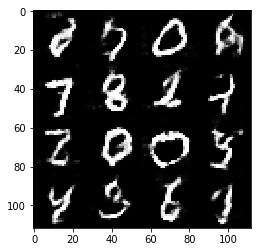

epoch 1/2 *** discriminator loss: 1.2007 *** generator loss: 0.7933
epoch 1/2 *** discriminator loss: 1.1727 *** generator loss: 1.1847
epoch 1/2 *** discriminator loss: 1.1721 *** generator loss: 1.2293
epoch 1/2 *** discriminator loss: 1.0329 *** generator loss: 1.0009
epoch 1/2 *** discriminator loss: 1.1454 *** generator loss: 1.0760
epoch 1/2 *** discriminator loss: 1.0862 *** generator loss: 0.9378
epoch 1/2 *** discriminator loss: 1.3817 *** generator loss: 0.6579
epoch 1/2 *** discriminator loss: 1.1989 *** generator loss: 1.5560
epoch 1/2 *** discriminator loss: 1.2074 *** generator loss: 1.1042
epoch 1/2 *** discriminator loss: 1.1657 *** generator loss: 1.2149


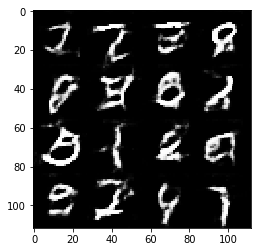

epoch 1/2 *** discriminator loss: 1.2383 *** generator loss: 0.7402
epoch 1/2 *** discriminator loss: 1.2888 *** generator loss: 1.1736
epoch 1/2 *** discriminator loss: 1.0958 *** generator loss: 1.1635
epoch 1/2 *** discriminator loss: 1.1802 *** generator loss: 1.4685
epoch 1/2 *** discriminator loss: 1.1776 *** generator loss: 1.0214
epoch 1/2 *** discriminator loss: 1.1214 *** generator loss: 0.8221
epoch 1/2 *** discriminator loss: 1.0673 *** generator loss: 1.0127
epoch 1/2 *** discriminator loss: 1.1008 *** generator loss: 1.0313
epoch 1/2 *** discriminator loss: 1.2070 *** generator loss: 1.4061
epoch 1/2 *** discriminator loss: 1.1577 *** generator loss: 0.9230


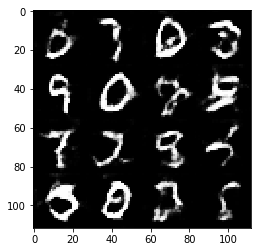

epoch 1/2 *** discriminator loss: 1.1588 *** generator loss: 0.9240
epoch 1/2 *** discriminator loss: 1.1554 *** generator loss: 1.6254
epoch 1/2 *** discriminator loss: 1.4890 *** generator loss: 0.4269
epoch 1/2 *** discriminator loss: 1.1173 *** generator loss: 1.2095
epoch 1/2 *** discriminator loss: 1.1964 *** generator loss: 1.1021
epoch 1/2 *** discriminator loss: 1.2710 *** generator loss: 1.4562
epoch 1/2 *** discriminator loss: 1.2740 *** generator loss: 0.8732
epoch 1/2 *** discriminator loss: 1.2583 *** generator loss: 0.7975
epoch 1/2 *** discriminator loss: 1.0630 *** generator loss: 1.0991
epoch 1/2 *** discriminator loss: 1.0168 *** generator loss: 1.0991


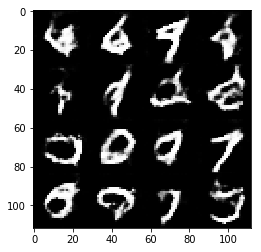

epoch 1/2 *** discriminator loss: 1.1923 *** generator loss: 1.5167
epoch 1/2 *** discriminator loss: 1.0514 *** generator loss: 1.0224
epoch 1/2 *** discriminator loss: 1.3039 *** generator loss: 0.5943
epoch 1/2 *** discriminator loss: 1.2067 *** generator loss: 1.0284
epoch 1/2 *** discriminator loss: 1.3019 *** generator loss: 0.6388
epoch 1/2 *** discriminator loss: 1.2584 *** generator loss: 1.0308
epoch 1/2 *** discriminator loss: 1.1393 *** generator loss: 0.8432
epoch 1/2 *** discriminator loss: 1.1585 *** generator loss: 1.1788
epoch 1/2 *** discriminator loss: 0.9836 *** generator loss: 1.2692
epoch 1/2 *** discriminator loss: 1.0988 *** generator loss: 0.9908


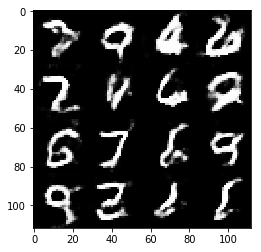

epoch 1/2 *** discriminator loss: 0.9938 *** generator loss: 0.9879
epoch 1/2 *** discriminator loss: 1.1432 *** generator loss: 0.7664
epoch 1/2 *** discriminator loss: 0.9495 *** generator loss: 1.1285
epoch 1/2 *** discriminator loss: 1.1652 *** generator loss: 1.2695
epoch 1/2 *** discriminator loss: 1.5530 *** generator loss: 0.4355
epoch 1/2 *** discriminator loss: 1.0846 *** generator loss: 0.9630
epoch 1/2 *** discriminator loss: 1.2759 *** generator loss: 1.6815
epoch 1/2 *** discriminator loss: 1.0849 *** generator loss: 1.2782
epoch 1/2 *** discriminator loss: 1.1533 *** generator loss: 1.4707
epoch 1/2 *** discriminator loss: 1.1103 *** generator loss: 1.2095


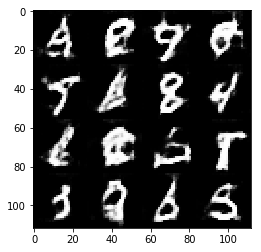

epoch 1/2 *** discriminator loss: 1.2992 *** generator loss: 0.7025
epoch 1/2 *** discriminator loss: 1.0954 *** generator loss: 0.7660
epoch 1/2 *** discriminator loss: 1.2824 *** generator loss: 1.8154
epoch 1/2 *** discriminator loss: 1.0441 *** generator loss: 1.6932
epoch 1/2 *** discriminator loss: 1.2398 *** generator loss: 1.0643
epoch 1/2 *** discriminator loss: 1.0183 *** generator loss: 0.9029
epoch 1/2 *** discriminator loss: 1.0055 *** generator loss: 0.9320
epoch 1/2 *** discriminator loss: 1.0672 *** generator loss: 1.6779
epoch 1/2 *** discriminator loss: 1.2886 *** generator loss: 1.3919
epoch 1/2 *** discriminator loss: 1.2370 *** generator loss: 1.5747


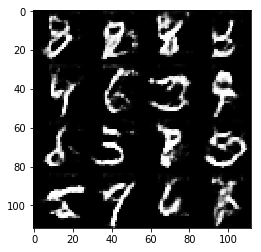

epoch 1/2 *** discriminator loss: 0.9430 *** generator loss: 1.6013
epoch 1/2 *** discriminator loss: 1.1599 *** generator loss: 1.4272
epoch 1/2 *** discriminator loss: 1.0689 *** generator loss: 0.7874
epoch 1/2 *** discriminator loss: 1.0852 *** generator loss: 1.0621
epoch 1/2 *** discriminator loss: 1.1633 *** generator loss: 0.7940
epoch 1/2 *** discriminator loss: 1.2441 *** generator loss: 0.7956
epoch 1/2 *** discriminator loss: 1.0201 *** generator loss: 1.0775
epoch 1/2 *** discriminator loss: 1.1930 *** generator loss: 1.3216
epoch 1/2 *** discriminator loss: 1.0542 *** generator loss: 1.0925
epoch 1/2 *** discriminator loss: 1.0424 *** generator loss: 1.1392


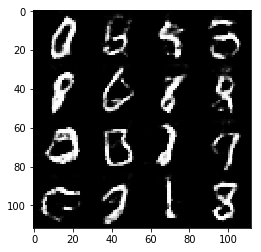

epoch 1/2 *** discriminator loss: 1.2082 *** generator loss: 0.6523
epoch 1/2 *** discriminator loss: 1.3387 *** generator loss: 1.7092
epoch 1/2 *** discriminator loss: 0.9966 *** generator loss: 1.0204
epoch 1/2 *** discriminator loss: 1.9772 *** generator loss: 0.2590
epoch 1/2 *** discriminator loss: 1.0169 *** generator loss: 1.0014
epoch 1/2 *** discriminator loss: 1.1391 *** generator loss: 0.9670
epoch 1/2 *** discriminator loss: 0.9263 *** generator loss: 1.4733
epoch 1/2 *** discriminator loss: 1.1529 *** generator loss: 1.4873
epoch 1/2 *** discriminator loss: 1.3854 *** generator loss: 0.4965
epoch 1/2 *** discriminator loss: 1.0291 *** generator loss: 1.5707


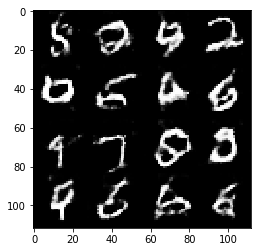

epoch 1/2 *** discriminator loss: 0.9528 *** generator loss: 1.3901
epoch 1/2 *** discriminator loss: 1.0759 *** generator loss: 0.8130
epoch 1/2 *** discriminator loss: 1.0371 *** generator loss: 1.5888
epoch 1/2 *** discriminator loss: 1.0137 *** generator loss: 0.9877
epoch 1/2 *** discriminator loss: 1.1612 *** generator loss: 0.7383
epoch 1/2 *** discriminator loss: 1.0306 *** generator loss: 1.4363
epoch 1/2 *** discriminator loss: 0.9524 *** generator loss: 1.1252
epoch 1/2 *** discriminator loss: 1.0927 *** generator loss: 0.7815
epoch 1/2 *** discriminator loss: 1.1858 *** generator loss: 1.8170
epoch 1/2 *** discriminator loss: 1.1153 *** generator loss: 1.7000


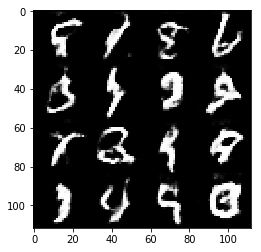

epoch 1/2 *** discriminator loss: 1.2049 *** generator loss: 1.5532
epoch 1/2 *** discriminator loss: 1.1969 *** generator loss: 1.3365
epoch 1/2 *** discriminator loss: 1.2546 *** generator loss: 1.3176
epoch 1/2 *** discriminator loss: 1.1184 *** generator loss: 0.8441
epoch 1/2 *** discriminator loss: 1.0519 *** generator loss: 1.9715
epoch 1/2 *** discriminator loss: 1.0117 *** generator loss: 0.9289
epoch 1/2 *** discriminator loss: 0.9005 *** generator loss: 1.3428
epoch 1/2 *** discriminator loss: 1.0767 *** generator loss: 0.9322
epoch 1/2 *** discriminator loss: 1.0413 *** generator loss: 1.1942
epoch 1/2 *** discriminator loss: 1.2381 *** generator loss: 1.9072


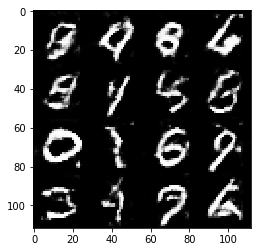

epoch 1/2 *** discriminator loss: 1.1170 *** generator loss: 1.7540
epoch 1/2 *** discriminator loss: 0.9609 *** generator loss: 1.0770
epoch 1/2 *** discriminator loss: 1.2504 *** generator loss: 1.1394
epoch 1/2 *** discriminator loss: 1.1454 *** generator loss: 1.4510
epoch 1/2 *** discriminator loss: 1.1280 *** generator loss: 0.7115
epoch 1/2 *** discriminator loss: 1.0224 *** generator loss: 1.2670
epoch 1/2 *** discriminator loss: 1.0691 *** generator loss: 1.1702
epoch 1/2 *** discriminator loss: 0.9456 *** generator loss: 1.2880
epoch 1/2 *** discriminator loss: 1.1569 *** generator loss: 0.7616
epoch 1/2 *** discriminator loss: 1.2387 *** generator loss: 1.6295


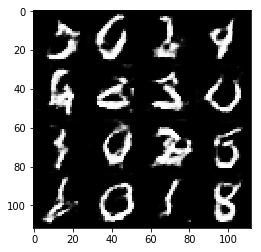

epoch 1/2 *** discriminator loss: 1.0005 *** generator loss: 1.1297
epoch 1/2 *** discriminator loss: 1.1348 *** generator loss: 0.9031
epoch 1/2 *** discriminator loss: 1.1055 *** generator loss: 0.9835
epoch 1/2 *** discriminator loss: 0.9847 *** generator loss: 1.0532
epoch 1/2 *** discriminator loss: 0.9993 *** generator loss: 1.4156
epoch 1/2 *** discriminator loss: 1.1013 *** generator loss: 0.7538
epoch 1/2 *** discriminator loss: 1.0825 *** generator loss: 1.3293
epoch 1/2 *** discriminator loss: 1.0588 *** generator loss: 0.9502
epoch 1/2 *** discriminator loss: 1.1931 *** generator loss: 1.7969
epoch 1/2 *** discriminator loss: 0.8764 *** generator loss: 1.1793


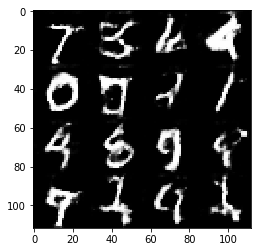

epoch 1/2 *** discriminator loss: 1.0799 *** generator loss: 0.7382
epoch 1/2 *** discriminator loss: 1.4019 *** generator loss: 0.4994
epoch 1/2 *** discriminator loss: 1.0995 *** generator loss: 0.9907
epoch 1/2 *** discriminator loss: 0.9890 *** generator loss: 1.2305
epoch 1/2 *** discriminator loss: 1.0403 *** generator loss: 0.9998
epoch 1/2 *** discriminator loss: 0.9685 *** generator loss: 1.0964
epoch 1/2 *** discriminator loss: 1.2508 *** generator loss: 1.9412
epoch 1/2 *** discriminator loss: 1.1728 *** generator loss: 1.8593
epoch 1/2 *** discriminator loss: 1.1806 *** generator loss: 1.0090
epoch 1/2 *** discriminator loss: 1.0552 *** generator loss: 1.0488


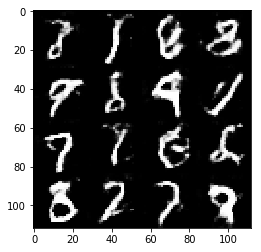

epoch 1/2 *** discriminator loss: 1.0382 *** generator loss: 0.9255
epoch 1/2 *** discriminator loss: 1.0464 *** generator loss: 1.5971
epoch 1/2 *** discriminator loss: 1.1773 *** generator loss: 0.6549
epoch 1/2 *** discriminator loss: 0.9981 *** generator loss: 0.9085
epoch 1/2 *** discriminator loss: 1.4806 *** generator loss: 1.9011
epoch 1/2 *** discriminator loss: 1.1945 *** generator loss: 0.7133
epoch 1/2 *** discriminator loss: 1.0557 *** generator loss: 1.6664
epoch 1/2 *** discriminator loss: 1.0385 *** generator loss: 1.0721
epoch 1/2 *** discriminator loss: 0.9126 *** generator loss: 1.2784
epoch 1/2 *** discriminator loss: 0.9642 *** generator loss: 1.0620


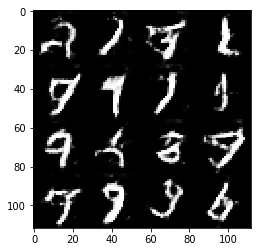

epoch 1/2 *** discriminator loss: 0.9486 *** generator loss: 1.0808
epoch 1/2 *** discriminator loss: 1.0832 *** generator loss: 1.0368
epoch 1/2 *** discriminator loss: 1.0317 *** generator loss: 1.1292
epoch 1/2 *** discriminator loss: 0.8289 *** generator loss: 1.8032
epoch 1/2 *** discriminator loss: 0.9875 *** generator loss: 1.4749
epoch 1/2 *** discriminator loss: 0.8906 *** generator loss: 1.0854
epoch 1/2 *** discriminator loss: 0.9363 *** generator loss: 1.3079
epoch 1/2 *** discriminator loss: 1.0174 *** generator loss: 1.2946
epoch 1/2 *** discriminator loss: 0.9501 *** generator loss: 1.5162
epoch 1/2 *** discriminator loss: 1.1913 *** generator loss: 0.8979


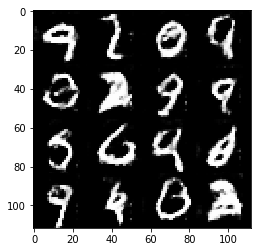

epoch 1/2 *** discriminator loss: 0.9118 *** generator loss: 1.6116
epoch 1/2 *** discriminator loss: 0.9068 *** generator loss: 1.5486
epoch 1/2 *** discriminator loss: 1.0927 *** generator loss: 0.8764
epoch 1/2 *** discriminator loss: 0.8866 *** generator loss: 1.3746
epoch 1/2 *** discriminator loss: 0.8916 *** generator loss: 1.7512
epoch 1/2 *** discriminator loss: 1.0210 *** generator loss: 1.2505
epoch 1/2 *** discriminator loss: 1.1078 *** generator loss: 2.1248
epoch 1/2 *** discriminator loss: 1.0825 *** generator loss: 0.8543
epoch 1/2 *** discriminator loss: 0.9903 *** generator loss: 0.8429
epoch 1/2 *** discriminator loss: 1.0659 *** generator loss: 0.8831


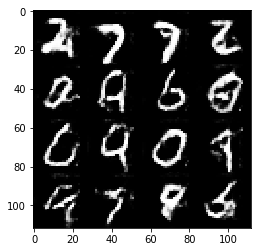

epoch 1/2 *** discriminator loss: 1.0007 *** generator loss: 2.0194
epoch 1/2 *** discriminator loss: 0.9202 *** generator loss: 1.1825
epoch 1/2 *** discriminator loss: 0.9567 *** generator loss: 1.1377
epoch 1/2 *** discriminator loss: 0.8628 *** generator loss: 1.5864
epoch 1/2 *** discriminator loss: 1.1408 *** generator loss: 0.8086
epoch 1/2 *** discriminator loss: 1.0044 *** generator loss: 1.2029
epoch 1/2 *** discriminator loss: 0.8539 *** generator loss: 1.3796
epoch 1/2 *** discriminator loss: 1.0121 *** generator loss: 1.5410
epoch 1/2 *** discriminator loss: 0.9692 *** generator loss: 1.0332
epoch 1/2 *** discriminator loss: 1.0130 *** generator loss: 2.0394


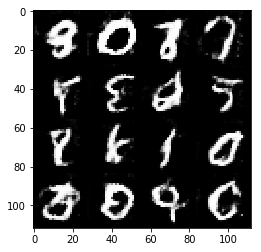

epoch 1/2 *** discriminator loss: 0.9555 *** generator loss: 1.0187
epoch 1/2 *** discriminator loss: 0.9548 *** generator loss: 1.2771
epoch 1/2 *** discriminator loss: 1.0083 *** generator loss: 0.8267
epoch 1/2 *** discriminator loss: 1.0540 *** generator loss: 1.1101
epoch 1/2 *** discriminator loss: 0.6796 *** generator loss: 2.0053
epoch 1/2 *** discriminator loss: 1.0182 *** generator loss: 1.2067
epoch 1/2 *** discriminator loss: 1.0731 *** generator loss: 2.2379
epoch 1/2 *** discriminator loss: 1.0409 *** generator loss: 1.2278
epoch 1/2 *** discriminator loss: 0.8992 *** generator loss: 1.0059
epoch 1/2 *** discriminator loss: 1.1565 *** generator loss: 0.6958


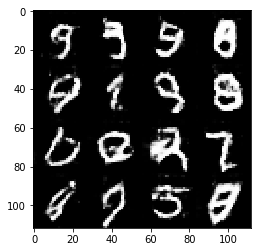

epoch 1/2 *** discriminator loss: 0.9491 *** generator loss: 1.4697
epoch 1/2 *** discriminator loss: 0.9056 *** generator loss: 1.1567
epoch 1/2 *** discriminator loss: 1.0365 *** generator loss: 1.6420
epoch 1/2 *** discriminator loss: 0.9859 *** generator loss: 1.8988
epoch 1/2 *** discriminator loss: 0.9942 *** generator loss: 1.7339
epoch 1/2 *** discriminator loss: 1.0008 *** generator loss: 1.2269
epoch 1/2 *** discriminator loss: 1.2310 *** generator loss: 2.1869
epoch 1/2 *** discriminator loss: 1.3655 *** generator loss: 0.5471
epoch 1/2 *** discriminator loss: 0.9152 *** generator loss: 1.6931
epoch 1/2 *** discriminator loss: 0.9908 *** generator loss: 1.2033


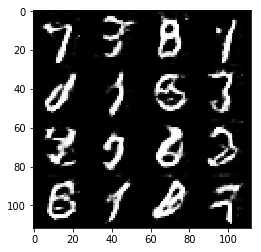

epoch 1/2 *** discriminator loss: 1.0142 *** generator loss: 1.4384
epoch 1/2 *** discriminator loss: 1.0631 *** generator loss: 0.7950
epoch 1/2 *** discriminator loss: 0.8845 *** generator loss: 1.2421
epoch 1/2 *** discriminator loss: 0.8887 *** generator loss: 1.1580
epoch 1/2 *** discriminator loss: 0.9365 *** generator loss: 1.3043
epoch 1/2 *** discriminator loss: 0.8997 *** generator loss: 1.5728
epoch 1/2 *** discriminator loss: 0.8816 *** generator loss: 1.5744
epoch 1/2 *** discriminator loss: 1.0887 *** generator loss: 1.2490
epoch 1/2 *** discriminator loss: 1.0272 *** generator loss: 1.4959
epoch 1/2 *** discriminator loss: 1.0160 *** generator loss: 1.1538


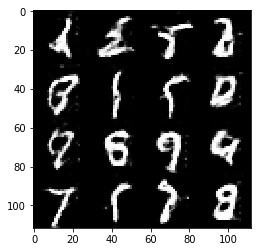

epoch 1/2 *** discriminator loss: 0.9931 *** generator loss: 1.6518
epoch 1/2 *** discriminator loss: 1.0551 *** generator loss: 1.7782
epoch 1/2 *** discriminator loss: 0.9425 *** generator loss: 1.7318
epoch 1/2 *** discriminator loss: 1.0111 *** generator loss: 1.0655
epoch 1/2 *** discriminator loss: 1.0388 *** generator loss: 2.2274
epoch 1/2 *** discriminator loss: 0.9331 *** generator loss: 1.2484
epoch 1/2 *** discriminator loss: 0.9127 *** generator loss: 1.4625
epoch 1/2 *** discriminator loss: 0.9600 *** generator loss: 1.7783
epoch 1/2 *** discriminator loss: 0.8641 *** generator loss: 1.3457
epoch 1/2 *** discriminator loss: 1.0465 *** generator loss: 1.6759


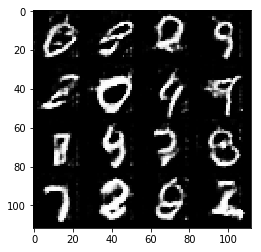

epoch 1/2 *** discriminator loss: 1.1266 *** generator loss: 1.5767
epoch 1/2 *** discriminator loss: 1.0886 *** generator loss: 1.9614
epoch 1/2 *** discriminator loss: 1.0034 *** generator loss: 2.3921
epoch 1/2 *** discriminator loss: 0.9680 *** generator loss: 1.2267
epoch 1/2 *** discriminator loss: 0.9362 *** generator loss: 1.2754
epoch 2/2 *** discriminator loss: 0.9870 *** generator loss: 1.2797
epoch 2/2 *** discriminator loss: 0.8050 *** generator loss: 1.4161
epoch 2/2 *** discriminator loss: 0.9078 *** generator loss: 1.1986
epoch 2/2 *** discriminator loss: 0.8816 *** generator loss: 1.0820
epoch 2/2 *** discriminator loss: 1.0964 *** generator loss: 1.6191


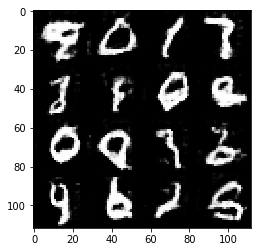

epoch 2/2 *** discriminator loss: 0.9462 *** generator loss: 1.4684
epoch 2/2 *** discriminator loss: 0.9026 *** generator loss: 1.0928
epoch 2/2 *** discriminator loss: 0.8045 *** generator loss: 1.8670
epoch 2/2 *** discriminator loss: 0.9950 *** generator loss: 1.1349
epoch 2/2 *** discriminator loss: 0.9649 *** generator loss: 1.1609
epoch 2/2 *** discriminator loss: 0.8940 *** generator loss: 1.0993
epoch 2/2 *** discriminator loss: 0.9502 *** generator loss: 1.7614
epoch 2/2 *** discriminator loss: 0.7977 *** generator loss: 1.2719
epoch 2/2 *** discriminator loss: 0.8733 *** generator loss: 1.4931
epoch 2/2 *** discriminator loss: 0.9398 *** generator loss: 1.2551


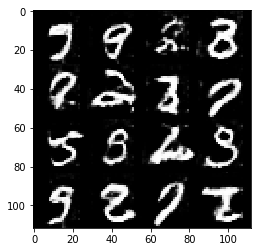

epoch 2/2 *** discriminator loss: 1.0855 *** generator loss: 0.9068
epoch 2/2 *** discriminator loss: 1.0147 *** generator loss: 0.9705
epoch 2/2 *** discriminator loss: 0.8308 *** generator loss: 1.1632
epoch 2/2 *** discriminator loss: 1.2868 *** generator loss: 0.6287
epoch 2/2 *** discriminator loss: 1.1347 *** generator loss: 0.8781
epoch 2/2 *** discriminator loss: 1.0230 *** generator loss: 1.8429
epoch 2/2 *** discriminator loss: 1.1653 *** generator loss: 0.8820
epoch 2/2 *** discriminator loss: 0.8605 *** generator loss: 1.2081
epoch 2/2 *** discriminator loss: 0.9032 *** generator loss: 1.8018
epoch 2/2 *** discriminator loss: 1.0121 *** generator loss: 1.6970


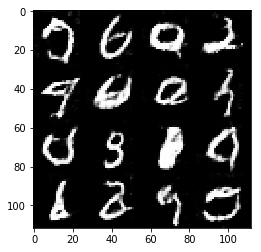

epoch 2/2 *** discriminator loss: 1.1523 *** generator loss: 1.2132
epoch 2/2 *** discriminator loss: 1.0163 *** generator loss: 2.2798
epoch 2/2 *** discriminator loss: 0.9866 *** generator loss: 0.9093
epoch 2/2 *** discriminator loss: 0.8386 *** generator loss: 1.5224
epoch 2/2 *** discriminator loss: 1.0809 *** generator loss: 0.7029
epoch 2/2 *** discriminator loss: 1.0569 *** generator loss: 2.2045
epoch 2/2 *** discriminator loss: 1.0576 *** generator loss: 1.1493
epoch 2/2 *** discriminator loss: 0.9207 *** generator loss: 1.0177
epoch 2/2 *** discriminator loss: 1.0272 *** generator loss: 1.8347
epoch 2/2 *** discriminator loss: 0.9818 *** generator loss: 1.1611


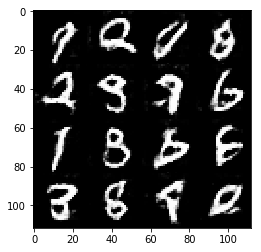

epoch 2/2 *** discriminator loss: 0.9469 *** generator loss: 1.4601
epoch 2/2 *** discriminator loss: 0.8678 *** generator loss: 1.8267
epoch 2/2 *** discriminator loss: 1.0001 *** generator loss: 1.9995
epoch 2/2 *** discriminator loss: 0.8910 *** generator loss: 1.2653
epoch 2/2 *** discriminator loss: 1.1193 *** generator loss: 0.7944
epoch 2/2 *** discriminator loss: 1.0105 *** generator loss: 0.9281
epoch 2/2 *** discriminator loss: 0.9470 *** generator loss: 1.3049
epoch 2/2 *** discriminator loss: 0.9188 *** generator loss: 1.5272
epoch 2/2 *** discriminator loss: 0.8098 *** generator loss: 1.6491
epoch 2/2 *** discriminator loss: 1.2975 *** generator loss: 2.0405


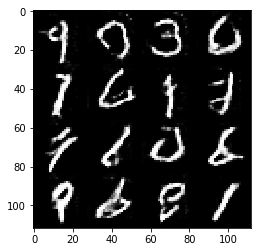

epoch 2/2 *** discriminator loss: 0.9846 *** generator loss: 1.9150
epoch 2/2 *** discriminator loss: 1.0456 *** generator loss: 0.7871
epoch 2/2 *** discriminator loss: 0.9927 *** generator loss: 1.4361
epoch 2/2 *** discriminator loss: 1.1010 *** generator loss: 0.7774
epoch 2/2 *** discriminator loss: 0.9264 *** generator loss: 1.5961
epoch 2/2 *** discriminator loss: 1.6151 *** generator loss: 2.6154
epoch 2/2 *** discriminator loss: 1.0388 *** generator loss: 0.8354
epoch 2/2 *** discriminator loss: 0.8876 *** generator loss: 1.2331
epoch 2/2 *** discriminator loss: 0.9918 *** generator loss: 1.1670
epoch 2/2 *** discriminator loss: 1.0316 *** generator loss: 1.0453


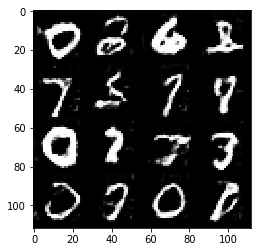

epoch 2/2 *** discriminator loss: 0.6895 *** generator loss: 1.7624
epoch 2/2 *** discriminator loss: 1.1555 *** generator loss: 0.7799
epoch 2/2 *** discriminator loss: 1.0338 *** generator loss: 1.6424
epoch 2/2 *** discriminator loss: 0.8894 *** generator loss: 1.5457
epoch 2/2 *** discriminator loss: 0.8409 *** generator loss: 1.1542
epoch 2/2 *** discriminator loss: 1.1688 *** generator loss: 2.1265
epoch 2/2 *** discriminator loss: 0.7920 *** generator loss: 1.2047
epoch 2/2 *** discriminator loss: 0.9666 *** generator loss: 1.3429
epoch 2/2 *** discriminator loss: 0.8697 *** generator loss: 1.6786
epoch 2/2 *** discriminator loss: 1.0618 *** generator loss: 0.8414


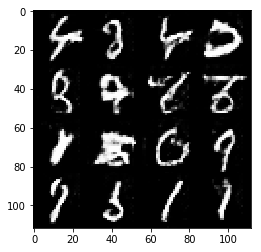

epoch 2/2 *** discriminator loss: 1.0796 *** generator loss: 1.2191
epoch 2/2 *** discriminator loss: 1.1116 *** generator loss: 1.0731
epoch 2/2 *** discriminator loss: 0.8638 *** generator loss: 1.9153
epoch 2/2 *** discriminator loss: 1.0863 *** generator loss: 0.8113
epoch 2/2 *** discriminator loss: 0.8030 *** generator loss: 1.6503
epoch 2/2 *** discriminator loss: 1.0003 *** generator loss: 1.0471
epoch 2/2 *** discriminator loss: 1.1143 *** generator loss: 0.8937
epoch 2/2 *** discriminator loss: 0.9288 *** generator loss: 1.0343
epoch 2/2 *** discriminator loss: 1.9216 *** generator loss: 3.5405
epoch 2/2 *** discriminator loss: 1.0237 *** generator loss: 1.4287


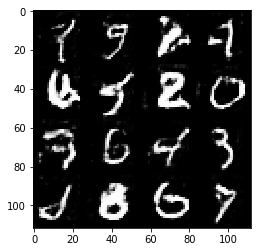

epoch 2/2 *** discriminator loss: 0.9079 *** generator loss: 1.1520
epoch 2/2 *** discriminator loss: 1.0623 *** generator loss: 2.0820
epoch 2/2 *** discriminator loss: 0.8786 *** generator loss: 1.4018
epoch 2/2 *** discriminator loss: 0.9143 *** generator loss: 1.4367
epoch 2/2 *** discriminator loss: 1.1339 *** generator loss: 0.7539
epoch 2/2 *** discriminator loss: 1.1202 *** generator loss: 1.4328
epoch 2/2 *** discriminator loss: 0.8821 *** generator loss: 1.0669
epoch 2/2 *** discriminator loss: 0.8952 *** generator loss: 1.3835
epoch 2/2 *** discriminator loss: 1.0281 *** generator loss: 1.6634
epoch 2/2 *** discriminator loss: 1.2734 *** generator loss: 1.6543


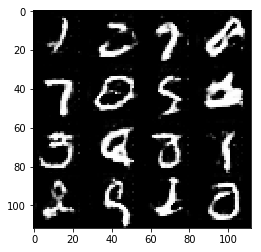

epoch 2/2 *** discriminator loss: 1.0670 *** generator loss: 1.8220
epoch 2/2 *** discriminator loss: 1.1163 *** generator loss: 0.7877
epoch 2/2 *** discriminator loss: 0.8010 *** generator loss: 1.9307
epoch 2/2 *** discriminator loss: 0.9524 *** generator loss: 1.3866
epoch 2/2 *** discriminator loss: 0.9735 *** generator loss: 1.1454
epoch 2/2 *** discriminator loss: 0.9911 *** generator loss: 0.9808
epoch 2/2 *** discriminator loss: 0.9428 *** generator loss: 1.1988
epoch 2/2 *** discriminator loss: 0.9502 *** generator loss: 1.1127
epoch 2/2 *** discriminator loss: 1.0003 *** generator loss: 1.7011
epoch 2/2 *** discriminator loss: 0.8797 *** generator loss: 1.1719


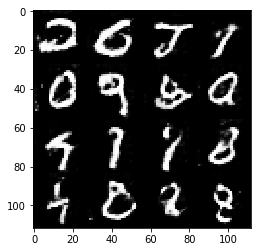

epoch 2/2 *** discriminator loss: 1.0725 *** generator loss: 1.0106
epoch 2/2 *** discriminator loss: 0.8840 *** generator loss: 1.4878
epoch 2/2 *** discriminator loss: 0.9566 *** generator loss: 0.9585
epoch 2/2 *** discriminator loss: 0.8908 *** generator loss: 1.5853
epoch 2/2 *** discriminator loss: 0.9687 *** generator loss: 1.2036
epoch 2/2 *** discriminator loss: 0.7431 *** generator loss: 1.7365
epoch 2/2 *** discriminator loss: 1.1281 *** generator loss: 0.7589
epoch 2/2 *** discriminator loss: 0.9262 *** generator loss: 1.1038
epoch 2/2 *** discriminator loss: 0.9248 *** generator loss: 0.9655
epoch 2/2 *** discriminator loss: 1.1244 *** generator loss: 0.7639


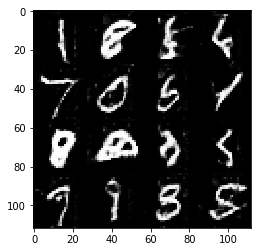

epoch 2/2 *** discriminator loss: 1.0562 *** generator loss: 1.2139
epoch 2/2 *** discriminator loss: 1.0201 *** generator loss: 1.0783
epoch 2/2 *** discriminator loss: 0.8060 *** generator loss: 1.3247
epoch 2/2 *** discriminator loss: 1.0174 *** generator loss: 0.9792
epoch 2/2 *** discriminator loss: 1.1014 *** generator loss: 1.8039
epoch 2/2 *** discriminator loss: 0.8695 *** generator loss: 1.6039
epoch 2/2 *** discriminator loss: 0.8975 *** generator loss: 1.0090
epoch 2/2 *** discriminator loss: 0.9116 *** generator loss: 1.2086
epoch 2/2 *** discriminator loss: 0.9455 *** generator loss: 1.5639
epoch 2/2 *** discriminator loss: 1.0438 *** generator loss: 1.3872


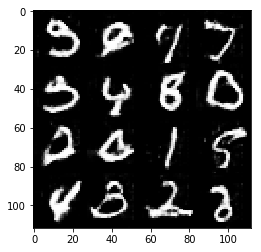

epoch 2/2 *** discriminator loss: 0.9937 *** generator loss: 0.9178
epoch 2/2 *** discriminator loss: 1.6265 *** generator loss: 2.3389
epoch 2/2 *** discriminator loss: 0.9423 *** generator loss: 1.8441
epoch 2/2 *** discriminator loss: 1.0247 *** generator loss: 0.7537
epoch 2/2 *** discriminator loss: 0.8319 *** generator loss: 1.4427
epoch 2/2 *** discriminator loss: 0.7681 *** generator loss: 1.5161
epoch 2/2 *** discriminator loss: 0.8164 *** generator loss: 1.5825
epoch 2/2 *** discriminator loss: 0.9288 *** generator loss: 1.2822
epoch 2/2 *** discriminator loss: 0.9623 *** generator loss: 1.9680
epoch 2/2 *** discriminator loss: 0.8352 *** generator loss: 1.4581


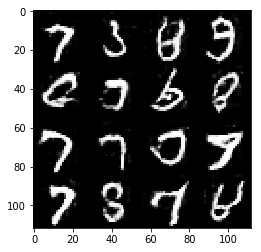

epoch 2/2 *** discriminator loss: 0.8053 *** generator loss: 2.3349
epoch 2/2 *** discriminator loss: 1.0769 *** generator loss: 1.0628
epoch 2/2 *** discriminator loss: 1.1472 *** generator loss: 1.1962
epoch 2/2 *** discriminator loss: 0.7780 *** generator loss: 1.4582
epoch 2/2 *** discriminator loss: 0.9227 *** generator loss: 1.5965
epoch 2/2 *** discriminator loss: 1.0552 *** generator loss: 0.9240
epoch 2/2 *** discriminator loss: 1.0572 *** generator loss: 1.5578
epoch 2/2 *** discriminator loss: 0.9242 *** generator loss: 1.2891
epoch 2/2 *** discriminator loss: 0.9746 *** generator loss: 0.8549
epoch 2/2 *** discriminator loss: 0.9015 *** generator loss: 1.9374


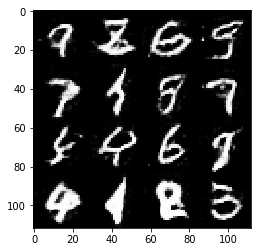

epoch 2/2 *** discriminator loss: 0.9678 *** generator loss: 1.0268
epoch 2/2 *** discriminator loss: 0.9597 *** generator loss: 1.1994
epoch 2/2 *** discriminator loss: 0.8625 *** generator loss: 1.3528
epoch 2/2 *** discriminator loss: 0.8137 *** generator loss: 1.2614
epoch 2/2 *** discriminator loss: 0.9209 *** generator loss: 1.9981
epoch 2/2 *** discriminator loss: 1.4590 *** generator loss: 0.4928
epoch 2/2 *** discriminator loss: 0.8456 *** generator loss: 1.2934
epoch 2/2 *** discriminator loss: 0.9357 *** generator loss: 1.3116
epoch 2/2 *** discriminator loss: 1.0625 *** generator loss: 1.5279
epoch 2/2 *** discriminator loss: 0.9689 *** generator loss: 1.3907


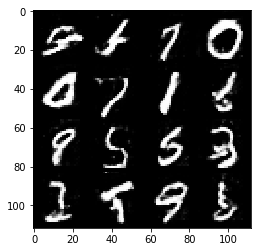

epoch 2/2 *** discriminator loss: 0.9046 *** generator loss: 1.5475
epoch 2/2 *** discriminator loss: 1.0708 *** generator loss: 0.8029
epoch 2/2 *** discriminator loss: 1.1641 *** generator loss: 0.7835
epoch 2/2 *** discriminator loss: 0.9932 *** generator loss: 1.1866
epoch 2/2 *** discriminator loss: 0.9353 *** generator loss: 1.7690
epoch 2/2 *** discriminator loss: 0.9548 *** generator loss: 2.2129
epoch 2/2 *** discriminator loss: 1.0951 *** generator loss: 1.5572
epoch 2/2 *** discriminator loss: 0.9023 *** generator loss: 1.5033
epoch 2/2 *** discriminator loss: 1.1772 *** generator loss: 1.4956
epoch 2/2 *** discriminator loss: 1.0020 *** generator loss: 0.8259


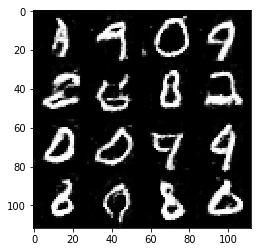

epoch 2/2 *** discriminator loss: 1.1210 *** generator loss: 1.2613
epoch 2/2 *** discriminator loss: 0.9736 *** generator loss: 1.4784
epoch 2/2 *** discriminator loss: 0.8285 *** generator loss: 1.6896
epoch 2/2 *** discriminator loss: 0.8773 *** generator loss: 1.4353
epoch 2/2 *** discriminator loss: 1.5611 *** generator loss: 0.3863
epoch 2/2 *** discriminator loss: 0.9976 *** generator loss: 0.8191
epoch 2/2 *** discriminator loss: 1.0184 *** generator loss: 1.5433
epoch 2/2 *** discriminator loss: 0.9379 *** generator loss: 1.3004
epoch 2/2 *** discriminator loss: 0.8768 *** generator loss: 1.2354
epoch 2/2 *** discriminator loss: 1.0056 *** generator loss: 1.7331


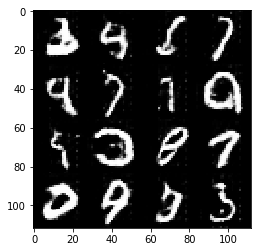

epoch 2/2 *** discriminator loss: 1.1152 *** generator loss: 1.2232
epoch 2/2 *** discriminator loss: 0.9773 *** generator loss: 1.1347
epoch 2/2 *** discriminator loss: 0.8598 *** generator loss: 1.2892
epoch 2/2 *** discriminator loss: 1.0063 *** generator loss: 2.2033
epoch 2/2 *** discriminator loss: 1.0100 *** generator loss: 1.7521
epoch 2/2 *** discriminator loss: 1.0676 *** generator loss: 0.9940
epoch 2/2 *** discriminator loss: 1.0792 *** generator loss: 1.0819
epoch 2/2 *** discriminator loss: 0.9334 *** generator loss: 1.4814
epoch 2/2 *** discriminator loss: 1.1471 *** generator loss: 2.7898
epoch 2/2 *** discriminator loss: 0.9438 *** generator loss: 1.5140


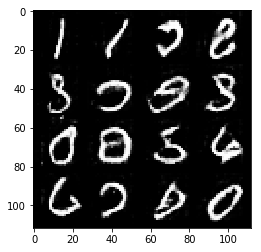

epoch 2/2 *** discriminator loss: 0.9054 *** generator loss: 1.3943
epoch 2/2 *** discriminator loss: 0.8569 *** generator loss: 1.1190
epoch 2/2 *** discriminator loss: 1.1006 *** generator loss: 2.0112
epoch 2/2 *** discriminator loss: 0.8671 *** generator loss: 1.1217
epoch 2/2 *** discriminator loss: 0.9192 *** generator loss: 0.9974
epoch 2/2 *** discriminator loss: 0.8708 *** generator loss: 1.2172
epoch 2/2 *** discriminator loss: 0.9062 *** generator loss: 1.9669
epoch 2/2 *** discriminator loss: 1.2322 *** generator loss: 0.8611
epoch 2/2 *** discriminator loss: 1.0941 *** generator loss: 1.0093
epoch 2/2 *** discriminator loss: 0.9610 *** generator loss: 0.9221


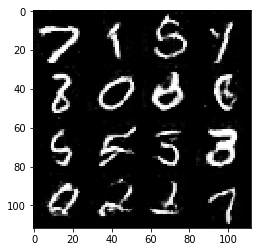

epoch 2/2 *** discriminator loss: 0.8114 *** generator loss: 1.5170
epoch 2/2 *** discriminator loss: 1.0537 *** generator loss: 0.9402
epoch 2/2 *** discriminator loss: 0.9852 *** generator loss: 1.0762
epoch 2/2 *** discriminator loss: 0.9355 *** generator loss: 1.1975
epoch 2/2 *** discriminator loss: 0.9443 *** generator loss: 1.2478
epoch 2/2 *** discriminator loss: 0.9590 *** generator loss: 1.5789
epoch 2/2 *** discriminator loss: 0.9597 *** generator loss: 2.5533
epoch 2/2 *** discriminator loss: 1.0231 *** generator loss: 1.2026
epoch 2/2 *** discriminator loss: 1.0702 *** generator loss: 1.5175
epoch 2/2 *** discriminator loss: 1.0087 *** generator loss: 0.7762


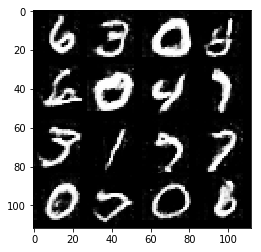

epoch 2/2 *** discriminator loss: 1.0803 *** generator loss: 0.9099
epoch 2/2 *** discriminator loss: 1.0538 *** generator loss: 1.6923
epoch 2/2 *** discriminator loss: 0.9284 *** generator loss: 1.2109
epoch 2/2 *** discriminator loss: 0.9210 *** generator loss: 1.2666
epoch 2/2 *** discriminator loss: 0.9957 *** generator loss: 1.3139
epoch 2/2 *** discriminator loss: 0.9084 *** generator loss: 1.6865
epoch 2/2 *** discriminator loss: 0.7752 *** generator loss: 1.3708
epoch 2/2 *** discriminator loss: 0.9927 *** generator loss: 1.2693
epoch 2/2 *** discriminator loss: 0.8106 *** generator loss: 1.1430
epoch 2/2 *** discriminator loss: 0.9759 *** generator loss: 1.1036


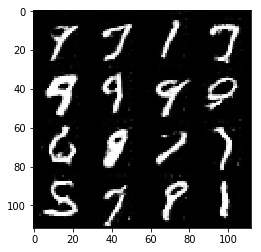

epoch 2/2 *** discriminator loss: 0.9625 *** generator loss: 1.6450
epoch 2/2 *** discriminator loss: 0.9974 *** generator loss: 1.3078
epoch 2/2 *** discriminator loss: 0.9895 *** generator loss: 1.2936
epoch 2/2 *** discriminator loss: 0.8641 *** generator loss: 1.1420
epoch 2/2 *** discriminator loss: 1.0049 *** generator loss: 1.0302
epoch 2/2 *** discriminator loss: 1.0646 *** generator loss: 1.0212
epoch 2/2 *** discriminator loss: 0.9095 *** generator loss: 1.2090
epoch 2/2 *** discriminator loss: 0.9048 *** generator loss: 1.5980
epoch 2/2 *** discriminator loss: 1.0787 *** generator loss: 1.6778
epoch 2/2 *** discriminator loss: 0.9329 *** generator loss: 1.5428


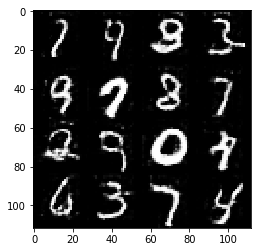

epoch 2/2 *** discriminator loss: 0.9512 *** generator loss: 1.5513
epoch 2/2 *** discriminator loss: 1.1239 *** generator loss: 1.1465
epoch 2/2 *** discriminator loss: 0.9183 *** generator loss: 1.2877
epoch 2/2 *** discriminator loss: 0.9869 *** generator loss: 1.7511
epoch 2/2 *** discriminator loss: 0.9137 *** generator loss: 1.3777
epoch 2/2 *** discriminator loss: 0.9175 *** generator loss: 1.2649
epoch 2/2 *** discriminator loss: 0.9470 *** generator loss: 1.4288
epoch 2/2 *** discriminator loss: 1.0530 *** generator loss: 0.8490
epoch 2/2 *** discriminator loss: 0.9530 *** generator loss: 1.7797
epoch 2/2 *** discriminator loss: 1.0364 *** generator loss: 1.0176


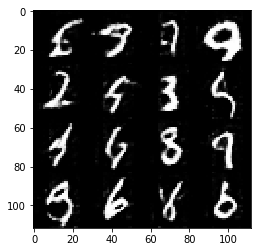

epoch 2/2 *** discriminator loss: 0.8992 *** generator loss: 1.1299
epoch 2/2 *** discriminator loss: 0.8961 *** generator loss: 1.8287
epoch 2/2 *** discriminator loss: 0.9292 *** generator loss: 1.4008
epoch 2/2 *** discriminator loss: 0.9058 *** generator loss: 1.5930
epoch 2/2 *** discriminator loss: 0.9933 *** generator loss: 1.1594
epoch 2/2 *** discriminator loss: 0.9113 *** generator loss: 1.1716
epoch 2/2 *** discriminator loss: 0.9747 *** generator loss: 1.0546
epoch 2/2 *** discriminator loss: 0.8148 *** generator loss: 1.3758
epoch 2/2 *** discriminator loss: 1.0798 *** generator loss: 1.0090
epoch 2/2 *** discriminator loss: 1.4590 *** generator loss: 2.2666


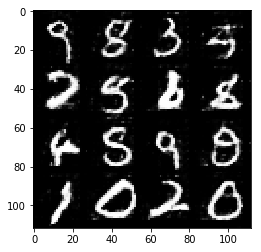

epoch 2/2 *** discriminator loss: 1.0512 *** generator loss: 0.9519
epoch 2/2 *** discriminator loss: 0.9488 *** generator loss: 1.7897
epoch 2/2 *** discriminator loss: 1.1273 *** generator loss: 1.4108
epoch 2/2 *** discriminator loss: 0.9134 *** generator loss: 1.2302
epoch 2/2 *** discriminator loss: 0.9153 *** generator loss: 2.3106
epoch 2/2 *** discriminator loss: 0.9752 *** generator loss: 1.0880
epoch 2/2 *** discriminator loss: 0.9729 *** generator loss: 2.3751
epoch 2/2 *** discriminator loss: 1.0698 *** generator loss: 1.3313
epoch 2/2 *** discriminator loss: 0.9720 *** generator loss: 1.5077
epoch 2/2 *** discriminator loss: 0.9568 *** generator loss: 1.7393


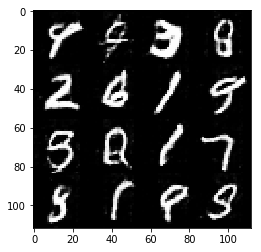

epoch 2/2 *** discriminator loss: 0.9752 *** generator loss: 1.1158
epoch 2/2 *** discriminator loss: 0.8633 *** generator loss: 1.3141
epoch 2/2 *** discriminator loss: 1.0286 *** generator loss: 0.9265
epoch 2/2 *** discriminator loss: 0.8462 *** generator loss: 1.3347
epoch 2/2 *** discriminator loss: 0.9056 *** generator loss: 1.3203
epoch 2/2 *** discriminator loss: 0.8822 *** generator loss: 1.1863
epoch 2/2 *** discriminator loss: 0.8724 *** generator loss: 1.1257
epoch 2/2 *** discriminator loss: 0.9390 *** generator loss: 1.4576
epoch 2/2 *** discriminator loss: 0.9530 *** generator loss: 1.2118
epoch 2/2 *** discriminator loss: 0.8029 *** generator loss: 1.9846


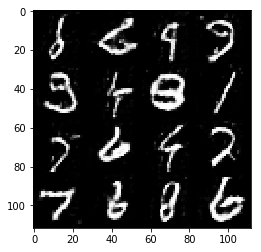

epoch 2/2 *** discriminator loss: 1.0113 *** generator loss: 0.9969
epoch 2/2 *** discriminator loss: 0.8031 *** generator loss: 1.3722
epoch 2/2 *** discriminator loss: 0.7998 *** generator loss: 1.2705
epoch 2/2 *** discriminator loss: 0.9795 *** generator loss: 1.1769
epoch 2/2 *** discriminator loss: 0.9990 *** generator loss: 1.4609
epoch 2/2 *** discriminator loss: 0.8069 *** generator loss: 1.7422
epoch 2/2 *** discriminator loss: 0.9343 *** generator loss: 1.5278
epoch 2/2 *** discriminator loss: 0.9883 *** generator loss: 1.3229
epoch 2/2 *** discriminator loss: 1.0542 *** generator loss: 0.7932
epoch 2/2 *** discriminator loss: 1.2017 *** generator loss: 0.8218


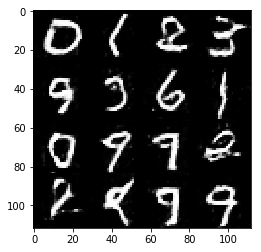

epoch 2/2 *** discriminator loss: 1.0134 *** generator loss: 1.2050
epoch 2/2 *** discriminator loss: 1.0822 *** generator loss: 1.0912
epoch 2/2 *** discriminator loss: 1.0685 *** generator loss: 1.2147
epoch 2/2 *** discriminator loss: 0.9687 *** generator loss: 1.5770
epoch 2/2 *** discriminator loss: 0.8361 *** generator loss: 1.4030
epoch 2/2 *** discriminator loss: 0.9561 *** generator loss: 1.1939
epoch 2/2 *** discriminator loss: 1.0502 *** generator loss: 0.9821
epoch 2/2 *** discriminator loss: 1.0327 *** generator loss: 1.1295
epoch 2/2 *** discriminator loss: 1.0924 *** generator loss: 0.7424
epoch 2/2 *** discriminator loss: 0.8666 *** generator loss: 1.2519


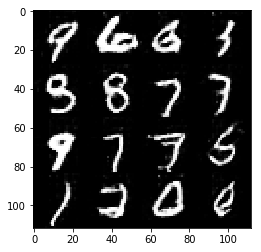

epoch 2/2 *** discriminator loss: 0.8761 *** generator loss: 1.6682
epoch 2/2 *** discriminator loss: 0.9614 *** generator loss: 1.1425
epoch 2/2 *** discriminator loss: 1.0733 *** generator loss: 1.0919
epoch 2/2 *** discriminator loss: 0.7531 *** generator loss: 1.3409
epoch 2/2 *** discriminator loss: 1.0944 *** generator loss: 1.4312
epoch 2/2 *** discriminator loss: 0.9450 *** generator loss: 1.2963
epoch 2/2 *** discriminator loss: 1.0222 *** generator loss: 1.5175
epoch 2/2 *** discriminator loss: 1.0405 *** generator loss: 1.3377
epoch 2/2 *** discriminator loss: 0.7545 *** generator loss: 1.6073
epoch 2/2 *** discriminator loss: 0.9931 *** generator loss: 1.2998


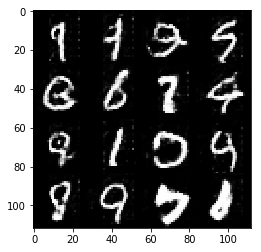

epoch 2/2 *** discriminator loss: 1.1579 *** generator loss: 1.8873
epoch 2/2 *** discriminator loss: 0.9213 *** generator loss: 1.3664
epoch 2/2 *** discriminator loss: 0.9868 *** generator loss: 1.7045
epoch 2/2 *** discriminator loss: 1.1738 *** generator loss: 0.9932
epoch 2/2 *** discriminator loss: 0.8176 *** generator loss: 1.1604
epoch 2/2 *** discriminator loss: 0.9744 *** generator loss: 1.2993
epoch 2/2 *** discriminator loss: 0.9187 *** generator loss: 1.5689
epoch 2/2 *** discriminator loss: 1.0116 *** generator loss: 1.5888
epoch 2/2 *** discriminator loss: 0.8654 *** generator loss: 1.1822
epoch 2/2 *** discriminator loss: 1.0532 *** generator loss: 0.8851


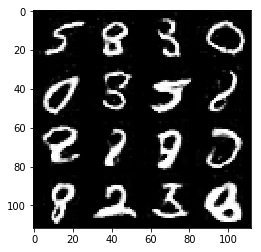

epoch 2/2 *** discriminator loss: 0.9663 *** generator loss: 1.8747
epoch 2/2 *** discriminator loss: 1.1356 *** generator loss: 0.8258
epoch 2/2 *** discriminator loss: 0.8988 *** generator loss: 1.2355
epoch 2/2 *** discriminator loss: 0.9384 *** generator loss: 1.6476
epoch 2/2 *** discriminator loss: 1.0910 *** generator loss: 0.8627
epoch 2/2 *** discriminator loss: 1.0262 *** generator loss: 0.9492
epoch 2/2 *** discriminator loss: 0.9877 *** generator loss: 1.2180
epoch 2/2 *** discriminator loss: 0.9682 *** generator loss: 1.3248
epoch 2/2 *** discriminator loss: 1.0435 *** generator loss: 1.7018
epoch 2/2 *** discriminator loss: 0.9510 *** generator loss: 0.8173


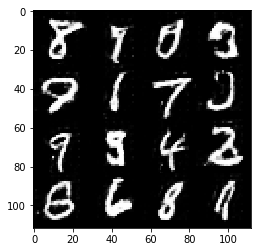

epoch 2/2 *** discriminator loss: 0.8988 *** generator loss: 1.6119
epoch 2/2 *** discriminator loss: 0.9326 *** generator loss: 1.2577
epoch 2/2 *** discriminator loss: 0.9068 *** generator loss: 1.3193
epoch 2/2 *** discriminator loss: 0.7994 *** generator loss: 1.1933
epoch 2/2 *** discriminator loss: 1.0595 *** generator loss: 0.8805
epoch 2/2 *** discriminator loss: 1.0020 *** generator loss: 1.1933
epoch 2/2 *** discriminator loss: 0.8879 *** generator loss: 1.3516
epoch 2/2 *** discriminator loss: 0.9722 *** generator loss: 0.9847
epoch 2/2 *** discriminator loss: 0.9866 *** generator loss: 1.0643
epoch 2/2 *** discriminator loss: 0.9674 *** generator loss: 1.3444


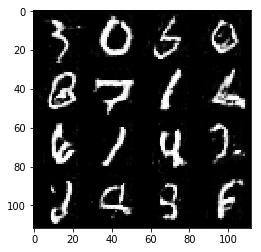

epoch 2/2 *** discriminator loss: 1.0401 *** generator loss: 1.0186
epoch 2/2 *** discriminator loss: 0.9585 *** generator loss: 1.9166
epoch 2/2 *** discriminator loss: 0.9069 *** generator loss: 1.5076
epoch 2/2 *** discriminator loss: 1.1422 *** generator loss: 0.7640
epoch 2/2 *** discriminator loss: 1.0824 *** generator loss: 0.7316
epoch 2/2 *** discriminator loss: 1.4796 *** generator loss: 2.4066
epoch 2/2 *** discriminator loss: 1.0167 *** generator loss: 1.0732
epoch 2/2 *** discriminator loss: 1.0133 *** generator loss: 0.9232
epoch 2/2 *** discriminator loss: 0.7617 *** generator loss: 1.7278
epoch 2/2 *** discriminator loss: 1.1408 *** generator loss: 1.0102


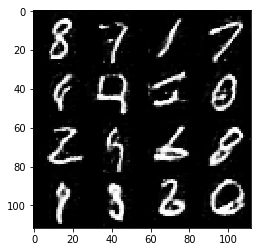

epoch 2/2 *** discriminator loss: 0.8869 *** generator loss: 1.2572
epoch 2/2 *** discriminator loss: 1.0113 *** generator loss: 1.0753
epoch 2/2 *** discriminator loss: 1.0880 *** generator loss: 2.5654
epoch 2/2 *** discriminator loss: 0.8713 *** generator loss: 1.2226
epoch 2/2 *** discriminator loss: 0.9816 *** generator loss: 0.9696
epoch 2/2 *** discriminator loss: 0.9638 *** generator loss: 1.0980
epoch 2/2 *** discriminator loss: 0.9683 *** generator loss: 1.2922
epoch 2/2 *** discriminator loss: 0.9350 *** generator loss: 1.5224
epoch 2/2 *** discriminator loss: 0.9258 *** generator loss: 1.2490
epoch 2/2 *** discriminator loss: 1.0579 *** generator loss: 0.9795


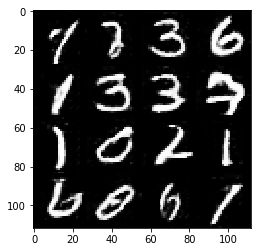

epoch 2/2 *** discriminator loss: 1.0835 *** generator loss: 0.9734
epoch 2/2 *** discriminator loss: 0.8590 *** generator loss: 1.5036
epoch 2/2 *** discriminator loss: 1.2437 *** generator loss: 0.7599
epoch 2/2 *** discriminator loss: 0.8973 *** generator loss: 1.0937
epoch 2/2 *** discriminator loss: 1.1901 *** generator loss: 0.7098
epoch 2/2 *** discriminator loss: 1.0052 *** generator loss: 1.4915
epoch 2/2 *** discriminator loss: 0.8051 *** generator loss: 1.8986
epoch 2/2 *** discriminator loss: 0.8507 *** generator loss: 1.4427
epoch 2/2 *** discriminator loss: 1.1346 *** generator loss: 1.6921
epoch 2/2 *** discriminator loss: 0.8479 *** generator loss: 1.9376


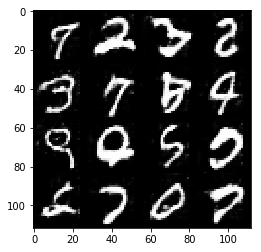

epoch 2/2 *** discriminator loss: 0.9039 *** generator loss: 1.1695
epoch 2/2 *** discriminator loss: 0.9753 *** generator loss: 1.1722
epoch 2/2 *** discriminator loss: 1.2047 *** generator loss: 0.7553
epoch 2/2 *** discriminator loss: 0.9858 *** generator loss: 1.0675
epoch 2/2 *** discriminator loss: 1.0480 *** generator loss: 1.2174
epoch 2/2 *** discriminator loss: 0.9678 *** generator loss: 1.6566
epoch 2/2 *** discriminator loss: 0.9239 *** generator loss: 1.1864
epoch 2/2 *** discriminator loss: 1.0522 *** generator loss: 1.0398
epoch 2/2 *** discriminator loss: 1.0142 *** generator loss: 1.0733
epoch 2/2 *** discriminator loss: 1.0371 *** generator loss: 1.0425


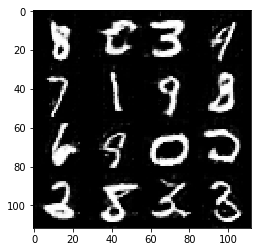

epoch 2/2 *** discriminator loss: 0.8936 *** generator loss: 1.3573
epoch 2/2 *** discriminator loss: 0.9970 *** generator loss: 1.1596
epoch 2/2 *** discriminator loss: 1.0923 *** generator loss: 1.8749
epoch 2/2 *** discriminator loss: 0.8762 *** generator loss: 1.2334
epoch 2/2 *** discriminator loss: 0.9548 *** generator loss: 1.3656
epoch 2/2 *** discriminator loss: 0.8432 *** generator loss: 1.8154
epoch 2/2 *** discriminator loss: 0.9666 *** generator loss: 1.0095
epoch 2/2 *** discriminator loss: 0.8288 *** generator loss: 1.4501
epoch 2/2 *** discriminator loss: 1.0888 *** generator loss: 1.5073
epoch 2/2 *** discriminator loss: 1.0188 *** generator loss: 1.5022


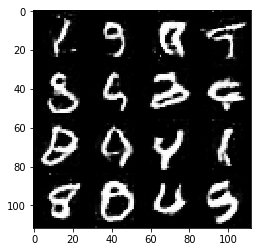

epoch 2/2 *** discriminator loss: 0.9856 *** generator loss: 1.2931
epoch 2/2 *** discriminator loss: 0.8856 *** generator loss: 1.3623
epoch 2/2 *** discriminator loss: 0.8257 *** generator loss: 1.2282
epoch 2/2 *** discriminator loss: 1.1435 *** generator loss: 0.7964
epoch 2/2 *** discriminator loss: 0.8773 *** generator loss: 1.3084
epoch 2/2 *** discriminator loss: 0.9596 *** generator loss: 1.1520
epoch 2/2 *** discriminator loss: 0.9682 *** generator loss: 1.4431
epoch 2/2 *** discriminator loss: 0.7819 *** generator loss: 1.3719
epoch 2/2 *** discriminator loss: 0.9966 *** generator loss: 1.3843
epoch 2/2 *** discriminator loss: 0.8256 *** generator loss: 1.5637


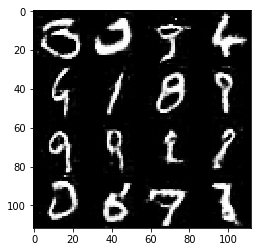

In [21]:
batch_size = 16
z_dim = 100
learning_rate = 0.00035
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1/1 *** discriminator loss: 1.7971 *** generator loss: 1.0052
epoch 1/1 *** discriminator loss: 1.0955 *** generator loss: 4.1848
epoch 1/1 *** discriminator loss: 1.1377 *** generator loss: 4.4336
epoch 1/1 *** discriminator loss: 1.6614 *** generator loss: 3.9760
epoch 1/1 *** discriminator loss: 1.2191 *** generator loss: 4.1880
epoch 1/1 *** discriminator loss: 1.1724 *** generator loss: 4.7975
epoch 1/1 *** discriminator loss: 0.6932 *** generator loss: 4.5518
epoch 1/1 *** discriminator loss: 0.6494 *** generator loss: 4.0086
epoch 1/1 *** discriminator loss: 1.0918 *** generator loss: 5.0815
epoch 1/1 *** discriminator loss: 0.5462 *** generator loss: 3.5764


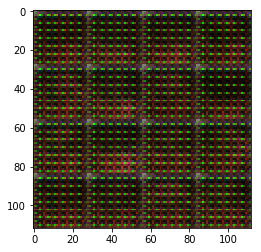

epoch 1/1 *** discriminator loss: 0.7292 *** generator loss: 4.0021
epoch 1/1 *** discriminator loss: 0.7214 *** generator loss: 2.6471
epoch 1/1 *** discriminator loss: 0.7080 *** generator loss: 2.3035
epoch 1/1 *** discriminator loss: 0.7259 *** generator loss: 2.5766
epoch 1/1 *** discriminator loss: 0.8705 *** generator loss: 1.9261
epoch 1/1 *** discriminator loss: 0.9197 *** generator loss: 1.3344
epoch 1/1 *** discriminator loss: 0.8363 *** generator loss: 1.8143
epoch 1/1 *** discriminator loss: 0.8072 *** generator loss: 2.1434
epoch 1/1 *** discriminator loss: 0.9101 *** generator loss: 2.1899
epoch 1/1 *** discriminator loss: 1.0476 *** generator loss: 1.1610


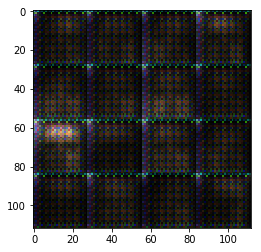

epoch 1/1 *** discriminator loss: 0.9925 *** generator loss: 1.5258
epoch 1/1 *** discriminator loss: 1.0341 *** generator loss: 1.3946
epoch 1/1 *** discriminator loss: 0.9068 *** generator loss: 2.1330
epoch 1/1 *** discriminator loss: 1.0223 *** generator loss: 1.7519
epoch 1/1 *** discriminator loss: 1.2922 *** generator loss: 2.0859
epoch 1/1 *** discriminator loss: 1.0120 *** generator loss: 1.3450
epoch 1/1 *** discriminator loss: 1.0117 *** generator loss: 1.5602
epoch 1/1 *** discriminator loss: 1.2088 *** generator loss: 1.5815
epoch 1/1 *** discriminator loss: 1.1465 *** generator loss: 1.6369
epoch 1/1 *** discriminator loss: 0.9374 *** generator loss: 2.0622


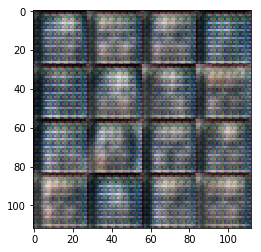

epoch 1/1 *** discriminator loss: 1.0837 *** generator loss: 1.5676
epoch 1/1 *** discriminator loss: 1.4153 *** generator loss: 1.2589
epoch 1/1 *** discriminator loss: 1.3994 *** generator loss: 1.2295
epoch 1/1 *** discriminator loss: 1.4080 *** generator loss: 1.5381
epoch 1/1 *** discriminator loss: 1.4565 *** generator loss: 1.4064
epoch 1/1 *** discriminator loss: 1.6054 *** generator loss: 0.9595
epoch 1/1 *** discriminator loss: 1.1385 *** generator loss: 1.1915
epoch 1/1 *** discriminator loss: 1.2170 *** generator loss: 1.4042
epoch 1/1 *** discriminator loss: 1.2221 *** generator loss: 0.9370
epoch 1/1 *** discriminator loss: 1.3400 *** generator loss: 0.8680


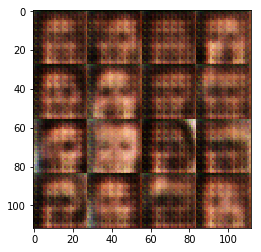

epoch 1/1 *** discriminator loss: 1.4174 *** generator loss: 1.3776
epoch 1/1 *** discriminator loss: 1.0771 *** generator loss: 1.1828
epoch 1/1 *** discriminator loss: 1.4598 *** generator loss: 0.7252
epoch 1/1 *** discriminator loss: 1.4314 *** generator loss: 1.1472
epoch 1/1 *** discriminator loss: 1.2461 *** generator loss: 1.3327
epoch 1/1 *** discriminator loss: 1.2232 *** generator loss: 1.0648
epoch 1/1 *** discriminator loss: 1.0152 *** generator loss: 1.2819
epoch 1/1 *** discriminator loss: 1.3583 *** generator loss: 1.0359
epoch 1/1 *** discriminator loss: 1.1058 *** generator loss: 1.1548
epoch 1/1 *** discriminator loss: 1.3403 *** generator loss: 0.9842


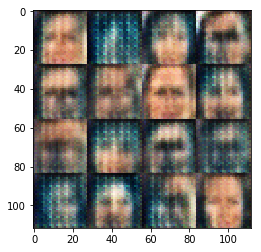

epoch 1/1 *** discriminator loss: 1.1244 *** generator loss: 1.1314
epoch 1/1 *** discriminator loss: 1.2313 *** generator loss: 1.2301
epoch 1/1 *** discriminator loss: 1.1686 *** generator loss: 0.9280
epoch 1/1 *** discriminator loss: 1.4158 *** generator loss: 0.9941
epoch 1/1 *** discriminator loss: 1.2889 *** generator loss: 1.1758
epoch 1/1 *** discriminator loss: 1.3254 *** generator loss: 1.1109
epoch 1/1 *** discriminator loss: 1.2879 *** generator loss: 0.9222
epoch 1/1 *** discriminator loss: 1.0435 *** generator loss: 1.3958
epoch 1/1 *** discriminator loss: 1.3640 *** generator loss: 0.7159
epoch 1/1 *** discriminator loss: 1.0092 *** generator loss: 1.2957


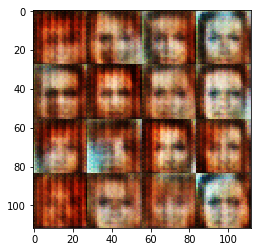

epoch 1/1 *** discriminator loss: 1.3298 *** generator loss: 1.0941
epoch 1/1 *** discriminator loss: 1.1774 *** generator loss: 1.2442
epoch 1/1 *** discriminator loss: 1.2161 *** generator loss: 1.0834
epoch 1/1 *** discriminator loss: 1.1035 *** generator loss: 1.3224
epoch 1/1 *** discriminator loss: 1.0758 *** generator loss: 1.2633
epoch 1/1 *** discriminator loss: 1.3374 *** generator loss: 1.3089
epoch 1/1 *** discriminator loss: 1.0468 *** generator loss: 1.3187
epoch 1/1 *** discriminator loss: 1.2870 *** generator loss: 0.8443
epoch 1/1 *** discriminator loss: 1.3225 *** generator loss: 0.9784
epoch 1/1 *** discriminator loss: 1.1532 *** generator loss: 1.1737


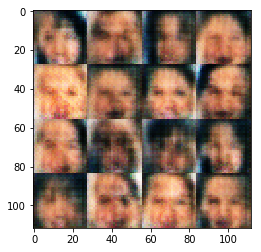

epoch 1/1 *** discriminator loss: 1.1918 *** generator loss: 1.0136
epoch 1/1 *** discriminator loss: 1.3621 *** generator loss: 1.1450
epoch 1/1 *** discriminator loss: 1.1749 *** generator loss: 1.3258
epoch 1/1 *** discriminator loss: 1.5721 *** generator loss: 0.9645
epoch 1/1 *** discriminator loss: 1.1741 *** generator loss: 1.0926
epoch 1/1 *** discriminator loss: 1.2612 *** generator loss: 1.6358
epoch 1/1 *** discriminator loss: 1.3558 *** generator loss: 1.2504
epoch 1/1 *** discriminator loss: 1.2301 *** generator loss: 0.6995
epoch 1/1 *** discriminator loss: 0.9613 *** generator loss: 1.2293
epoch 1/1 *** discriminator loss: 1.0483 *** generator loss: 1.2280


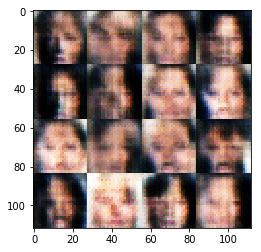

epoch 1/1 *** discriminator loss: 1.1699 *** generator loss: 1.5866
epoch 1/1 *** discriminator loss: 1.0890 *** generator loss: 1.4692
epoch 1/1 *** discriminator loss: 1.1000 *** generator loss: 1.3507
epoch 1/1 *** discriminator loss: 1.2005 *** generator loss: 1.0039
epoch 1/1 *** discriminator loss: 1.1504 *** generator loss: 0.8868
epoch 1/1 *** discriminator loss: 1.1442 *** generator loss: 1.0411
epoch 1/1 *** discriminator loss: 1.2616 *** generator loss: 1.6444
epoch 1/1 *** discriminator loss: 1.2006 *** generator loss: 1.1938
epoch 1/1 *** discriminator loss: 1.1197 *** generator loss: 1.2481
epoch 1/1 *** discriminator loss: 1.3965 *** generator loss: 1.0742


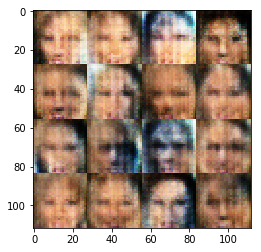

epoch 1/1 *** discriminator loss: 1.1718 *** generator loss: 1.3832
epoch 1/1 *** discriminator loss: 1.1927 *** generator loss: 1.2849
epoch 1/1 *** discriminator loss: 1.3249 *** generator loss: 0.9987
epoch 1/1 *** discriminator loss: 1.2906 *** generator loss: 1.0427
epoch 1/1 *** discriminator loss: 1.2693 *** generator loss: 1.3089
epoch 1/1 *** discriminator loss: 1.4191 *** generator loss: 1.2400
epoch 1/1 *** discriminator loss: 1.4187 *** generator loss: 1.0474
epoch 1/1 *** discriminator loss: 1.2323 *** generator loss: 1.1493
epoch 1/1 *** discriminator loss: 1.3081 *** generator loss: 1.1644
epoch 1/1 *** discriminator loss: 1.1079 *** generator loss: 1.0224


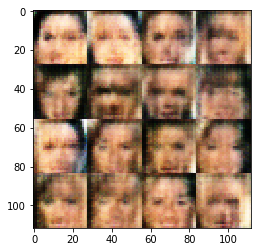

epoch 1/1 *** discriminator loss: 1.4030 *** generator loss: 0.9194
epoch 1/1 *** discriminator loss: 1.3371 *** generator loss: 0.9546
epoch 1/1 *** discriminator loss: 1.2574 *** generator loss: 0.8633
epoch 1/1 *** discriminator loss: 1.2188 *** generator loss: 1.0499
epoch 1/1 *** discriminator loss: 1.2854 *** generator loss: 1.0041
epoch 1/1 *** discriminator loss: 1.3699 *** generator loss: 0.8664
epoch 1/1 *** discriminator loss: 1.2877 *** generator loss: 1.0878
epoch 1/1 *** discriminator loss: 1.3706 *** generator loss: 1.0118
epoch 1/1 *** discriminator loss: 1.2020 *** generator loss: 1.2110
epoch 1/1 *** discriminator loss: 1.4634 *** generator loss: 0.7140


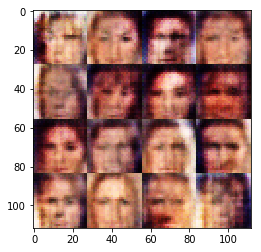

epoch 1/1 *** discriminator loss: 1.3681 *** generator loss: 0.8306
epoch 1/1 *** discriminator loss: 1.2158 *** generator loss: 1.0844
epoch 1/1 *** discriminator loss: 1.2101 *** generator loss: 1.2477
epoch 1/1 *** discriminator loss: 1.2617 *** generator loss: 0.9067
epoch 1/1 *** discriminator loss: 1.3079 *** generator loss: 0.9341
epoch 1/1 *** discriminator loss: 1.2075 *** generator loss: 0.9935
epoch 1/1 *** discriminator loss: 1.3187 *** generator loss: 0.9741
epoch 1/1 *** discriminator loss: 1.4564 *** generator loss: 0.7763
epoch 1/1 *** discriminator loss: 1.3241 *** generator loss: 1.2619
epoch 1/1 *** discriminator loss: 1.3725 *** generator loss: 1.0443


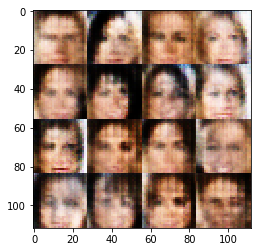

epoch 1/1 *** discriminator loss: 1.2946 *** generator loss: 0.8779
epoch 1/1 *** discriminator loss: 1.2851 *** generator loss: 1.2699
epoch 1/1 *** discriminator loss: 1.1997 *** generator loss: 1.1669
epoch 1/1 *** discriminator loss: 1.1768 *** generator loss: 1.1012
epoch 1/1 *** discriminator loss: 1.2419 *** generator loss: 1.0866
epoch 1/1 *** discriminator loss: 1.2718 *** generator loss: 0.8762
epoch 1/1 *** discriminator loss: 1.3142 *** generator loss: 0.8862
epoch 1/1 *** discriminator loss: 1.3778 *** generator loss: 0.9218
epoch 1/1 *** discriminator loss: 1.4338 *** generator loss: 1.0138
epoch 1/1 *** discriminator loss: 1.2650 *** generator loss: 0.9156


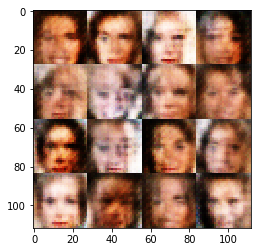

epoch 1/1 *** discriminator loss: 1.5052 *** generator loss: 0.9071
epoch 1/1 *** discriminator loss: 1.1555 *** generator loss: 1.1664
epoch 1/1 *** discriminator loss: 1.4203 *** generator loss: 0.7057
epoch 1/1 *** discriminator loss: 1.3789 *** generator loss: 0.7587
epoch 1/1 *** discriminator loss: 1.2903 *** generator loss: 0.9051
epoch 1/1 *** discriminator loss: 1.1622 *** generator loss: 1.2488
epoch 1/1 *** discriminator loss: 1.3391 *** generator loss: 1.1049
epoch 1/1 *** discriminator loss: 1.1489 *** generator loss: 1.0731
epoch 1/1 *** discriminator loss: 1.3447 *** generator loss: 0.8363
epoch 1/1 *** discriminator loss: 1.3500 *** generator loss: 0.8970


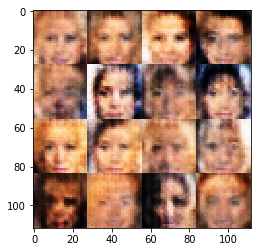

epoch 1/1 *** discriminator loss: 1.2581 *** generator loss: 0.9181
epoch 1/1 *** discriminator loss: 1.5099 *** generator loss: 0.8000
epoch 1/1 *** discriminator loss: 1.3041 *** generator loss: 0.8900
epoch 1/1 *** discriminator loss: 1.3197 *** generator loss: 0.8382
epoch 1/1 *** discriminator loss: 1.3891 *** generator loss: 0.7236
epoch 1/1 *** discriminator loss: 1.4956 *** generator loss: 0.6992
epoch 1/1 *** discriminator loss: 1.3281 *** generator loss: 0.8813
epoch 1/1 *** discriminator loss: 1.3486 *** generator loss: 1.0419
epoch 1/1 *** discriminator loss: 1.3471 *** generator loss: 0.8111
epoch 1/1 *** discriminator loss: 1.3307 *** generator loss: 0.9949


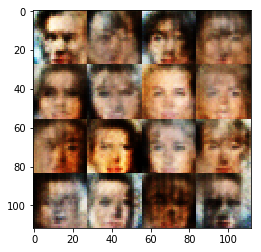

epoch 1/1 *** discriminator loss: 1.2889 *** generator loss: 0.9221
epoch 1/1 *** discriminator loss: 1.1686 *** generator loss: 1.1172
epoch 1/1 *** discriminator loss: 1.3443 *** generator loss: 0.8364
epoch 1/1 *** discriminator loss: 1.1144 *** generator loss: 1.0802
epoch 1/1 *** discriminator loss: 1.4294 *** generator loss: 1.0229
epoch 1/1 *** discriminator loss: 1.1732 *** generator loss: 1.0134
epoch 1/1 *** discriminator loss: 1.2774 *** generator loss: 0.9111
epoch 1/1 *** discriminator loss: 1.2550 *** generator loss: 1.0331
epoch 1/1 *** discriminator loss: 1.6118 *** generator loss: 0.7053
epoch 1/1 *** discriminator loss: 1.2978 *** generator loss: 0.9116


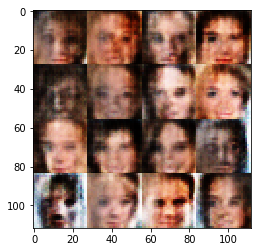

epoch 1/1 *** discriminator loss: 1.4732 *** generator loss: 0.7421
epoch 1/1 *** discriminator loss: 1.2826 *** generator loss: 0.9760
epoch 1/1 *** discriminator loss: 1.3182 *** generator loss: 0.8931
epoch 1/1 *** discriminator loss: 1.2536 *** generator loss: 0.9279
epoch 1/1 *** discriminator loss: 1.3024 *** generator loss: 1.1030
epoch 1/1 *** discriminator loss: 1.2773 *** generator loss: 1.1256
epoch 1/1 *** discriminator loss: 1.3199 *** generator loss: 1.1340
epoch 1/1 *** discriminator loss: 1.2711 *** generator loss: 0.9576
epoch 1/1 *** discriminator loss: 1.2021 *** generator loss: 1.0824
epoch 1/1 *** discriminator loss: 1.5186 *** generator loss: 0.9439


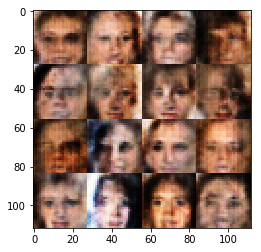

epoch 1/1 *** discriminator loss: 1.2767 *** generator loss: 1.0809
epoch 1/1 *** discriminator loss: 1.4063 *** generator loss: 0.7814
epoch 1/1 *** discriminator loss: 1.2629 *** generator loss: 0.9267
epoch 1/1 *** discriminator loss: 1.2192 *** generator loss: 0.9511
epoch 1/1 *** discriminator loss: 1.2063 *** generator loss: 0.8341
epoch 1/1 *** discriminator loss: 1.3807 *** generator loss: 0.8734
epoch 1/1 *** discriminator loss: 1.1658 *** generator loss: 1.1092
epoch 1/1 *** discriminator loss: 1.2489 *** generator loss: 1.0934
epoch 1/1 *** discriminator loss: 1.4430 *** generator loss: 0.8552
epoch 1/1 *** discriminator loss: 1.2361 *** generator loss: 0.9544


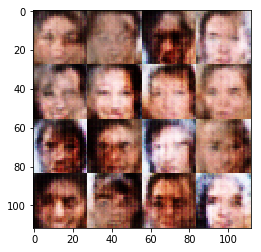

epoch 1/1 *** discriminator loss: 1.3443 *** generator loss: 0.9321
epoch 1/1 *** discriminator loss: 1.2664 *** generator loss: 0.8356
epoch 1/1 *** discriminator loss: 1.4900 *** generator loss: 1.1819
epoch 1/1 *** discriminator loss: 1.3561 *** generator loss: 0.9490
epoch 1/1 *** discriminator loss: 1.2997 *** generator loss: 0.9689
epoch 1/1 *** discriminator loss: 1.2392 *** generator loss: 0.8325
epoch 1/1 *** discriminator loss: 1.3236 *** generator loss: 0.8961
epoch 1/1 *** discriminator loss: 1.4347 *** generator loss: 0.9496
epoch 1/1 *** discriminator loss: 1.2754 *** generator loss: 1.0316
epoch 1/1 *** discriminator loss: 1.3332 *** generator loss: 0.8788


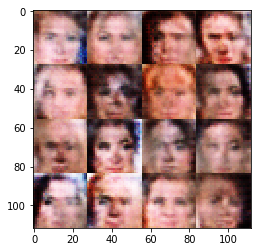

epoch 1/1 *** discriminator loss: 1.4419 *** generator loss: 1.1043
epoch 1/1 *** discriminator loss: 1.2034 *** generator loss: 1.0881
epoch 1/1 *** discriminator loss: 1.3586 *** generator loss: 0.9974
epoch 1/1 *** discriminator loss: 1.5273 *** generator loss: 0.8061
epoch 1/1 *** discriminator loss: 1.4314 *** generator loss: 0.9561
epoch 1/1 *** discriminator loss: 1.3670 *** generator loss: 0.9806
epoch 1/1 *** discriminator loss: 1.0990 *** generator loss: 1.4130
epoch 1/1 *** discriminator loss: 1.2570 *** generator loss: 0.9804
epoch 1/1 *** discriminator loss: 1.2429 *** generator loss: 1.1265
epoch 1/1 *** discriminator loss: 1.4012 *** generator loss: 0.7524


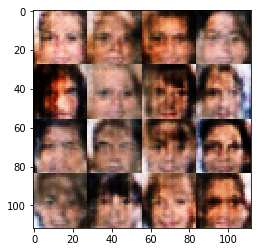

epoch 1/1 *** discriminator loss: 1.2808 *** generator loss: 1.0351
epoch 1/1 *** discriminator loss: 1.3125 *** generator loss: 0.9629
epoch 1/1 *** discriminator loss: 1.2768 *** generator loss: 1.1220
epoch 1/1 *** discriminator loss: 1.4397 *** generator loss: 0.7932
epoch 1/1 *** discriminator loss: 1.2051 *** generator loss: 1.0313
epoch 1/1 *** discriminator loss: 1.3900 *** generator loss: 0.8360
epoch 1/1 *** discriminator loss: 1.3705 *** generator loss: 0.9880
epoch 1/1 *** discriminator loss: 1.0967 *** generator loss: 1.1157
epoch 1/1 *** discriminator loss: 1.2225 *** generator loss: 0.9840
epoch 1/1 *** discriminator loss: 1.2218 *** generator loss: 1.1350


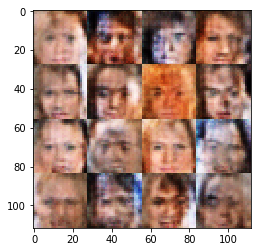

epoch 1/1 *** discriminator loss: 1.1904 *** generator loss: 1.1149
epoch 1/1 *** discriminator loss: 1.2520 *** generator loss: 0.9882
epoch 1/1 *** discriminator loss: 1.3197 *** generator loss: 1.1076
epoch 1/1 *** discriminator loss: 1.2076 *** generator loss: 1.1736
epoch 1/1 *** discriminator loss: 1.3081 *** generator loss: 1.1344
epoch 1/1 *** discriminator loss: 1.3014 *** generator loss: 0.9302
epoch 1/1 *** discriminator loss: 1.2175 *** generator loss: 0.9420
epoch 1/1 *** discriminator loss: 1.3482 *** generator loss: 0.8708
epoch 1/1 *** discriminator loss: 1.3233 *** generator loss: 0.8786
epoch 1/1 *** discriminator loss: 1.4300 *** generator loss: 0.9810


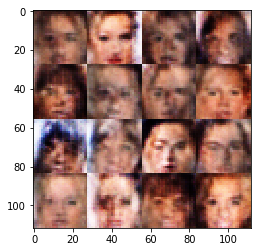

epoch 1/1 *** discriminator loss: 1.2830 *** generator loss: 1.1011
epoch 1/1 *** discriminator loss: 1.2055 *** generator loss: 1.1329
epoch 1/1 *** discriminator loss: 1.4147 *** generator loss: 0.7769
epoch 1/1 *** discriminator loss: 1.2601 *** generator loss: 0.9246
epoch 1/1 *** discriminator loss: 1.2739 *** generator loss: 0.9723
epoch 1/1 *** discriminator loss: 1.3915 *** generator loss: 0.7893
epoch 1/1 *** discriminator loss: 1.4561 *** generator loss: 0.8566
epoch 1/1 *** discriminator loss: 1.2733 *** generator loss: 0.9734
epoch 1/1 *** discriminator loss: 1.2275 *** generator loss: 1.0103
epoch 1/1 *** discriminator loss: 1.2041 *** generator loss: 1.1366


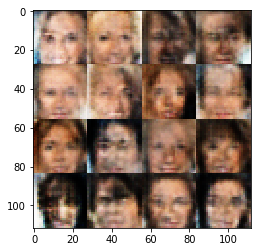

epoch 1/1 *** discriminator loss: 1.3895 *** generator loss: 0.9950
epoch 1/1 *** discriminator loss: 1.3934 *** generator loss: 0.7442
epoch 1/1 *** discriminator loss: 1.1806 *** generator loss: 1.2041
epoch 1/1 *** discriminator loss: 1.4259 *** generator loss: 0.8814
epoch 1/1 *** discriminator loss: 1.1728 *** generator loss: 0.9726
epoch 1/1 *** discriminator loss: 1.2951 *** generator loss: 0.9053
epoch 1/1 *** discriminator loss: 1.4765 *** generator loss: 0.7479
epoch 1/1 *** discriminator loss: 1.2612 *** generator loss: 0.9696
epoch 1/1 *** discriminator loss: 1.3132 *** generator loss: 1.0829
epoch 1/1 *** discriminator loss: 1.3352 *** generator loss: 0.9637


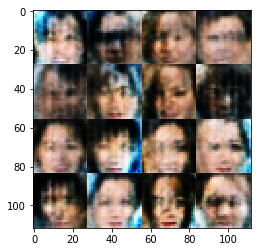

epoch 1/1 *** discriminator loss: 1.3092 *** generator loss: 0.8908
epoch 1/1 *** discriminator loss: 1.4680 *** generator loss: 0.8236
epoch 1/1 *** discriminator loss: 1.1788 *** generator loss: 1.0668
epoch 1/1 *** discriminator loss: 1.3513 *** generator loss: 0.8625
epoch 1/1 *** discriminator loss: 1.3807 *** generator loss: 0.8737
epoch 1/1 *** discriminator loss: 1.2856 *** generator loss: 0.8463
epoch 1/1 *** discriminator loss: 1.4056 *** generator loss: 0.7835
epoch 1/1 *** discriminator loss: 1.3199 *** generator loss: 0.8112
epoch 1/1 *** discriminator loss: 1.3854 *** generator loss: 0.9191
epoch 1/1 *** discriminator loss: 1.3768 *** generator loss: 0.8217


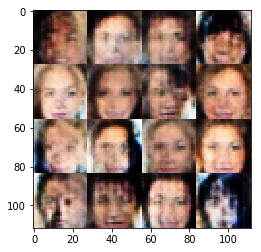

epoch 1/1 *** discriminator loss: 1.2486 *** generator loss: 0.8220
epoch 1/1 *** discriminator loss: 1.3563 *** generator loss: 0.8387
epoch 1/1 *** discriminator loss: 1.3825 *** generator loss: 0.8840
epoch 1/1 *** discriminator loss: 1.3968 *** generator loss: 0.8171
epoch 1/1 *** discriminator loss: 1.3465 *** generator loss: 0.9006
epoch 1/1 *** discriminator loss: 1.3986 *** generator loss: 0.9604
epoch 1/1 *** discriminator loss: 1.3078 *** generator loss: 0.9850
epoch 1/1 *** discriminator loss: 1.2307 *** generator loss: 0.9672
epoch 1/1 *** discriminator loss: 1.3040 *** generator loss: 0.8160
epoch 1/1 *** discriminator loss: 1.3421 *** generator loss: 0.8681


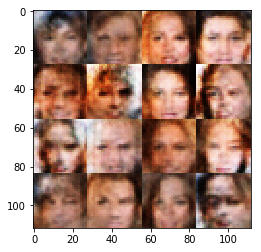

epoch 1/1 *** discriminator loss: 1.3407 *** generator loss: 1.0300
epoch 1/1 *** discriminator loss: 1.2213 *** generator loss: 0.9528
epoch 1/1 *** discriminator loss: 1.2509 *** generator loss: 1.0108
epoch 1/1 *** discriminator loss: 1.3387 *** generator loss: 0.8768
epoch 1/1 *** discriminator loss: 1.2773 *** generator loss: 1.1177
epoch 1/1 *** discriminator loss: 1.3474 *** generator loss: 0.8153
epoch 1/1 *** discriminator loss: 1.3033 *** generator loss: 1.0258
epoch 1/1 *** discriminator loss: 1.3154 *** generator loss: 0.8098
epoch 1/1 *** discriminator loss: 1.4379 *** generator loss: 0.8147
epoch 1/1 *** discriminator loss: 1.3561 *** generator loss: 0.8701


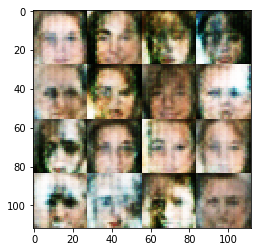

epoch 1/1 *** discriminator loss: 1.3468 *** generator loss: 0.8387
epoch 1/1 *** discriminator loss: 1.3251 *** generator loss: 0.8670
epoch 1/1 *** discriminator loss: 1.4135 *** generator loss: 0.8493
epoch 1/1 *** discriminator loss: 1.3170 *** generator loss: 0.9891
epoch 1/1 *** discriminator loss: 1.2439 *** generator loss: 0.9040
epoch 1/1 *** discriminator loss: 1.4205 *** generator loss: 1.0252
epoch 1/1 *** discriminator loss: 1.2810 *** generator loss: 1.0002
epoch 1/1 *** discriminator loss: 1.3087 *** generator loss: 0.8408
epoch 1/1 *** discriminator loss: 1.3510 *** generator loss: 0.8832
epoch 1/1 *** discriminator loss: 1.3078 *** generator loss: 0.9227


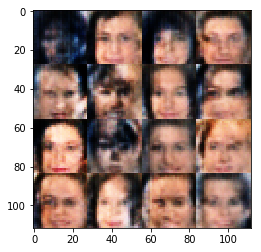

epoch 1/1 *** discriminator loss: 1.2739 *** generator loss: 1.0335
epoch 1/1 *** discriminator loss: 1.1137 *** generator loss: 1.0606
epoch 1/1 *** discriminator loss: 1.3087 *** generator loss: 0.8181
epoch 1/1 *** discriminator loss: 1.3347 *** generator loss: 0.8658
epoch 1/1 *** discriminator loss: 1.2908 *** generator loss: 0.9109
epoch 1/1 *** discriminator loss: 1.2653 *** generator loss: 0.8855
epoch 1/1 *** discriminator loss: 1.3963 *** generator loss: 0.9860
epoch 1/1 *** discriminator loss: 1.4478 *** generator loss: 0.7217
epoch 1/1 *** discriminator loss: 1.3089 *** generator loss: 1.0258
epoch 1/1 *** discriminator loss: 1.3093 *** generator loss: 0.8349


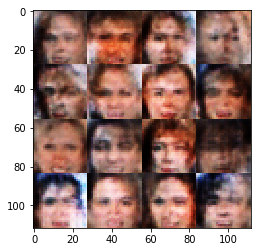

epoch 1/1 *** discriminator loss: 1.2162 *** generator loss: 1.0965
epoch 1/1 *** discriminator loss: 1.3766 *** generator loss: 0.8182
epoch 1/1 *** discriminator loss: 1.3835 *** generator loss: 0.9938
epoch 1/1 *** discriminator loss: 1.2364 *** generator loss: 0.9659
epoch 1/1 *** discriminator loss: 1.2572 *** generator loss: 1.0247
epoch 1/1 *** discriminator loss: 1.0927 *** generator loss: 1.0508
epoch 1/1 *** discriminator loss: 1.4324 *** generator loss: 0.9882
epoch 1/1 *** discriminator loss: 1.2428 *** generator loss: 0.9912
epoch 1/1 *** discriminator loss: 1.4611 *** generator loss: 0.8887
epoch 1/1 *** discriminator loss: 1.1565 *** generator loss: 1.0223


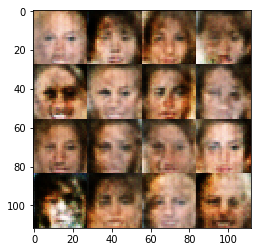

epoch 1/1 *** discriminator loss: 1.3035 *** generator loss: 0.8600
epoch 1/1 *** discriminator loss: 1.3322 *** generator loss: 0.8731
epoch 1/1 *** discriminator loss: 1.3449 *** generator loss: 0.7265
epoch 1/1 *** discriminator loss: 1.4321 *** generator loss: 0.7240
epoch 1/1 *** discriminator loss: 1.4533 *** generator loss: 0.7916
epoch 1/1 *** discriminator loss: 1.3083 *** generator loss: 0.9569
epoch 1/1 *** discriminator loss: 1.3895 *** generator loss: 0.9755
epoch 1/1 *** discriminator loss: 1.3705 *** generator loss: 0.8377
epoch 1/1 *** discriminator loss: 1.4049 *** generator loss: 0.7584
epoch 1/1 *** discriminator loss: 1.1677 *** generator loss: 1.1016


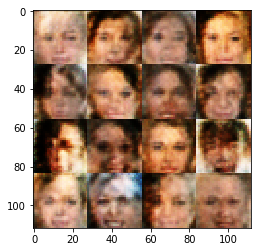

epoch 1/1 *** discriminator loss: 1.2841 *** generator loss: 0.8135
epoch 1/1 *** discriminator loss: 1.3876 *** generator loss: 0.9481
epoch 1/1 *** discriminator loss: 1.2631 *** generator loss: 0.8833
epoch 1/1 *** discriminator loss: 1.2699 *** generator loss: 1.0281
epoch 1/1 *** discriminator loss: 1.3399 *** generator loss: 0.9122
epoch 1/1 *** discriminator loss: 1.1754 *** generator loss: 1.1797
epoch 1/1 *** discriminator loss: 1.1765 *** generator loss: 1.0685
epoch 1/1 *** discriminator loss: 1.1870 *** generator loss: 1.1716
epoch 1/1 *** discriminator loss: 1.2632 *** generator loss: 1.0881
epoch 1/1 *** discriminator loss: 1.2192 *** generator loss: 1.0307


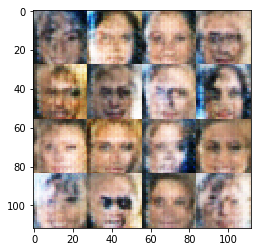

epoch 1/1 *** discriminator loss: 1.3655 *** generator loss: 0.7165
epoch 1/1 *** discriminator loss: 1.2843 *** generator loss: 0.9369
epoch 1/1 *** discriminator loss: 1.2749 *** generator loss: 0.9104
epoch 1/1 *** discriminator loss: 1.3221 *** generator loss: 1.0751
epoch 1/1 *** discriminator loss: 1.0895 *** generator loss: 1.2172
epoch 1/1 *** discriminator loss: 1.2165 *** generator loss: 1.4142
epoch 1/1 *** discriminator loss: 1.3445 *** generator loss: 0.7412
epoch 1/1 *** discriminator loss: 1.3652 *** generator loss: 0.8451
epoch 1/1 *** discriminator loss: 1.1911 *** generator loss: 0.9998
epoch 1/1 *** discriminator loss: 1.2670 *** generator loss: 0.9908


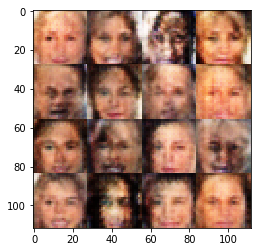

epoch 1/1 *** discriminator loss: 1.2564 *** generator loss: 0.9876
epoch 1/1 *** discriminator loss: 1.5181 *** generator loss: 0.7105
epoch 1/1 *** discriminator loss: 1.2821 *** generator loss: 0.8133
epoch 1/1 *** discriminator loss: 1.3383 *** generator loss: 1.1471
epoch 1/1 *** discriminator loss: 1.2228 *** generator loss: 1.0545
epoch 1/1 *** discriminator loss: 1.2403 *** generator loss: 1.1408
epoch 1/1 *** discriminator loss: 1.3031 *** generator loss: 1.0576
epoch 1/1 *** discriminator loss: 1.3117 *** generator loss: 0.9514
epoch 1/1 *** discriminator loss: 1.4072 *** generator loss: 0.8314
epoch 1/1 *** discriminator loss: 1.3487 *** generator loss: 1.0507


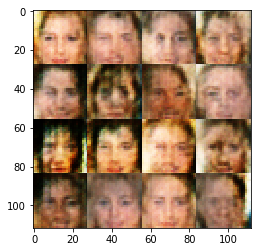

epoch 1/1 *** discriminator loss: 1.3097 *** generator loss: 0.9719
epoch 1/1 *** discriminator loss: 1.4061 *** generator loss: 0.7844
epoch 1/1 *** discriminator loss: 1.2243 *** generator loss: 0.9613
epoch 1/1 *** discriminator loss: 1.3965 *** generator loss: 0.9389
epoch 1/1 *** discriminator loss: 1.3055 *** generator loss: 0.9729
epoch 1/1 *** discriminator loss: 1.4147 *** generator loss: 0.8760
epoch 1/1 *** discriminator loss: 1.2893 *** generator loss: 0.8453
epoch 1/1 *** discriminator loss: 1.4112 *** generator loss: 0.8077
epoch 1/1 *** discriminator loss: 1.2306 *** generator loss: 1.0319
epoch 1/1 *** discriminator loss: 1.4905 *** generator loss: 0.7833


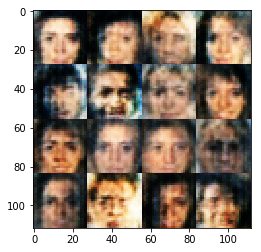

epoch 1/1 *** discriminator loss: 1.2251 *** generator loss: 1.0296
epoch 1/1 *** discriminator loss: 1.4774 *** generator loss: 0.7816
epoch 1/1 *** discriminator loss: 1.3944 *** generator loss: 0.8355
epoch 1/1 *** discriminator loss: 1.2902 *** generator loss: 0.8841
epoch 1/1 *** discriminator loss: 1.4292 *** generator loss: 0.8430
epoch 1/1 *** discriminator loss: 1.4065 *** generator loss: 0.8936
epoch 1/1 *** discriminator loss: 1.3395 *** generator loss: 0.8770
epoch 1/1 *** discriminator loss: 1.2020 *** generator loss: 1.0895
epoch 1/1 *** discriminator loss: 1.3389 *** generator loss: 0.8443
epoch 1/1 *** discriminator loss: 1.3667 *** generator loss: 0.8453


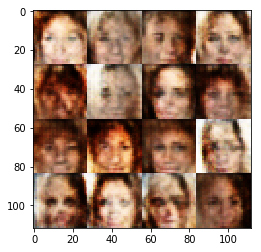

epoch 1/1 *** discriminator loss: 1.2938 *** generator loss: 0.8337
epoch 1/1 *** discriminator loss: 1.1118 *** generator loss: 1.0842
epoch 1/1 *** discriminator loss: 1.4001 *** generator loss: 0.7591
epoch 1/1 *** discriminator loss: 1.3615 *** generator loss: 0.9678
epoch 1/1 *** discriminator loss: 1.3349 *** generator loss: 0.8968
epoch 1/1 *** discriminator loss: 1.3650 *** generator loss: 0.8321
epoch 1/1 *** discriminator loss: 1.2420 *** generator loss: 0.8967
epoch 1/1 *** discriminator loss: 1.2749 *** generator loss: 1.0738
epoch 1/1 *** discriminator loss: 1.3982 *** generator loss: 0.9317
epoch 1/1 *** discriminator loss: 1.3565 *** generator loss: 0.9000


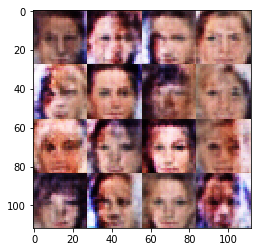

epoch 1/1 *** discriminator loss: 1.2032 *** generator loss: 1.0620
epoch 1/1 *** discriminator loss: 1.3220 *** generator loss: 0.7837
epoch 1/1 *** discriminator loss: 1.2584 *** generator loss: 1.1903
epoch 1/1 *** discriminator loss: 1.3032 *** generator loss: 0.9802
epoch 1/1 *** discriminator loss: 1.3031 *** generator loss: 0.9249
epoch 1/1 *** discriminator loss: 1.4036 *** generator loss: 0.7317
epoch 1/1 *** discriminator loss: 1.3030 *** generator loss: 0.9282
epoch 1/1 *** discriminator loss: 1.2864 *** generator loss: 0.8808
epoch 1/1 *** discriminator loss: 1.4318 *** generator loss: 0.8282
epoch 1/1 *** discriminator loss: 1.2812 *** generator loss: 0.9048


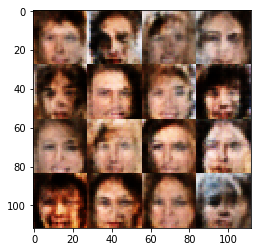

epoch 1/1 *** discriminator loss: 1.3467 *** generator loss: 1.0217
epoch 1/1 *** discriminator loss: 1.3319 *** generator loss: 0.8244
epoch 1/1 *** discriminator loss: 1.4373 *** generator loss: 0.8061
epoch 1/1 *** discriminator loss: 1.3528 *** generator loss: 0.9853
epoch 1/1 *** discriminator loss: 1.2590 *** generator loss: 0.8428
epoch 1/1 *** discriminator loss: 1.3125 *** generator loss: 0.9570
epoch 1/1 *** discriminator loss: 1.2743 *** generator loss: 1.0107
epoch 1/1 *** discriminator loss: 1.2969 *** generator loss: 0.9473
epoch 1/1 *** discriminator loss: 1.3420 *** generator loss: 0.9795
epoch 1/1 *** discriminator loss: 1.3439 *** generator loss: 0.8655


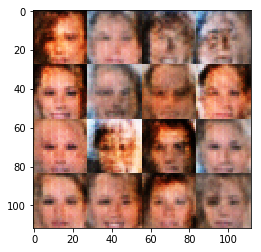

epoch 1/1 *** discriminator loss: 1.2327 *** generator loss: 0.9605
epoch 1/1 *** discriminator loss: 1.3092 *** generator loss: 0.9977
epoch 1/1 *** discriminator loss: 1.2782 *** generator loss: 0.8978
epoch 1/1 *** discriminator loss: 1.4212 *** generator loss: 0.8833
epoch 1/1 *** discriminator loss: 1.3305 *** generator loss: 0.8516
epoch 1/1 *** discriminator loss: 1.2982 *** generator loss: 0.8775
epoch 1/1 *** discriminator loss: 1.4007 *** generator loss: 0.9027
epoch 1/1 *** discriminator loss: 1.3405 *** generator loss: 0.9730
epoch 1/1 *** discriminator loss: 1.2379 *** generator loss: 0.8585
epoch 1/1 *** discriminator loss: 1.4102 *** generator loss: 0.8063


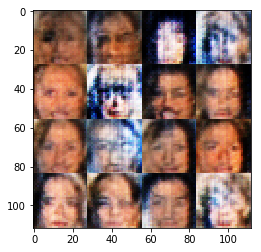

epoch 1/1 *** discriminator loss: 1.3992 *** generator loss: 0.8856
epoch 1/1 *** discriminator loss: 1.2626 *** generator loss: 1.0089
epoch 1/1 *** discriminator loss: 1.2332 *** generator loss: 0.8446
epoch 1/1 *** discriminator loss: 1.3263 *** generator loss: 0.8504
epoch 1/1 *** discriminator loss: 1.3105 *** generator loss: 1.0381
epoch 1/1 *** discriminator loss: 1.2155 *** generator loss: 0.8479
epoch 1/1 *** discriminator loss: 1.2358 *** generator loss: 0.9760
epoch 1/1 *** discriminator loss: 1.2725 *** generator loss: 1.0136
epoch 1/1 *** discriminator loss: 1.4035 *** generator loss: 0.8490
epoch 1/1 *** discriminator loss: 1.3684 *** generator loss: 0.9594


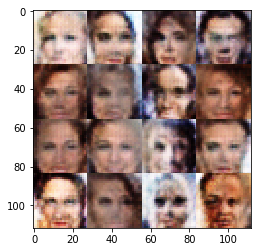

epoch 1/1 *** discriminator loss: 1.3459 *** generator loss: 0.8737
epoch 1/1 *** discriminator loss: 1.3502 *** generator loss: 0.9496
epoch 1/1 *** discriminator loss: 1.4020 *** generator loss: 1.0321
epoch 1/1 *** discriminator loss: 1.3681 *** generator loss: 0.9276
epoch 1/1 *** discriminator loss: 1.3561 *** generator loss: 0.8176
epoch 1/1 *** discriminator loss: 1.2488 *** generator loss: 1.1226
epoch 1/1 *** discriminator loss: 1.3205 *** generator loss: 0.9903
epoch 1/1 *** discriminator loss: 1.3055 *** generator loss: 0.9438
epoch 1/1 *** discriminator loss: 1.4045 *** generator loss: 0.9094
epoch 1/1 *** discriminator loss: 1.3171 *** generator loss: 1.0524


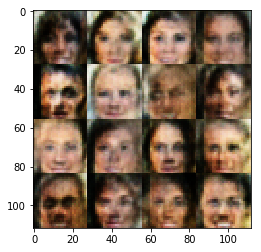

epoch 1/1 *** discriminator loss: 1.5150 *** generator loss: 0.7756
epoch 1/1 *** discriminator loss: 1.4165 *** generator loss: 0.8904
epoch 1/1 *** discriminator loss: 1.2836 *** generator loss: 0.9396
epoch 1/1 *** discriminator loss: 1.4717 *** generator loss: 0.8333
epoch 1/1 *** discriminator loss: 1.2847 *** generator loss: 0.9907
epoch 1/1 *** discriminator loss: 1.4422 *** generator loss: 0.8665
epoch 1/1 *** discriminator loss: 1.2196 *** generator loss: 0.9103
epoch 1/1 *** discriminator loss: 1.4237 *** generator loss: 0.8440
epoch 1/1 *** discriminator loss: 1.3164 *** generator loss: 0.8078
epoch 1/1 *** discriminator loss: 1.5005 *** generator loss: 0.7667


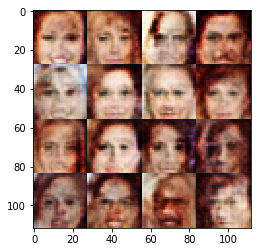

epoch 1/1 *** discriminator loss: 1.3211 *** generator loss: 0.8230
epoch 1/1 *** discriminator loss: 1.3472 *** generator loss: 0.8440
epoch 1/1 *** discriminator loss: 1.4107 *** generator loss: 0.8794
epoch 1/1 *** discriminator loss: 1.3609 *** generator loss: 0.9023
epoch 1/1 *** discriminator loss: 1.3508 *** generator loss: 1.0289
epoch 1/1 *** discriminator loss: 1.2048 *** generator loss: 0.9698
epoch 1/1 *** discriminator loss: 1.4422 *** generator loss: 0.7874
epoch 1/1 *** discriminator loss: 1.3874 *** generator loss: 0.8929
epoch 1/1 *** discriminator loss: 1.2570 *** generator loss: 0.9107
epoch 1/1 *** discriminator loss: 1.4002 *** generator loss: 0.7870


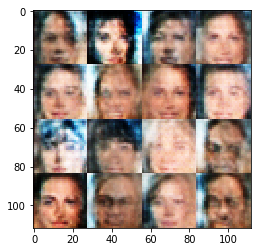

epoch 1/1 *** discriminator loss: 1.3364 *** generator loss: 0.8673
epoch 1/1 *** discriminator loss: 1.2435 *** generator loss: 1.0263
epoch 1/1 *** discriminator loss: 1.2869 *** generator loss: 0.8856
epoch 1/1 *** discriminator loss: 1.3206 *** generator loss: 0.8397
epoch 1/1 *** discriminator loss: 1.3020 *** generator loss: 0.8812
epoch 1/1 *** discriminator loss: 1.3712 *** generator loss: 0.9073
epoch 1/1 *** discriminator loss: 1.3293 *** generator loss: 1.0131
epoch 1/1 *** discriminator loss: 1.3821 *** generator loss: 0.9376
epoch 1/1 *** discriminator loss: 1.3023 *** generator loss: 0.9361
epoch 1/1 *** discriminator loss: 1.0824 *** generator loss: 1.1729


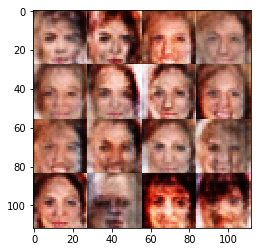

epoch 1/1 *** discriminator loss: 1.3048 *** generator loss: 0.8395
epoch 1/1 *** discriminator loss: 1.4073 *** generator loss: 0.8577
epoch 1/1 *** discriminator loss: 1.4072 *** generator loss: 0.8811
epoch 1/1 *** discriminator loss: 1.2707 *** generator loss: 0.9920
epoch 1/1 *** discriminator loss: 1.3342 *** generator loss: 0.9391
epoch 1/1 *** discriminator loss: 1.4753 *** generator loss: 0.9665
epoch 1/1 *** discriminator loss: 1.2451 *** generator loss: 1.0488
epoch 1/1 *** discriminator loss: 1.3411 *** generator loss: 0.8904
epoch 1/1 *** discriminator loss: 1.3780 *** generator loss: 0.7846
epoch 1/1 *** discriminator loss: 1.1981 *** generator loss: 1.0467


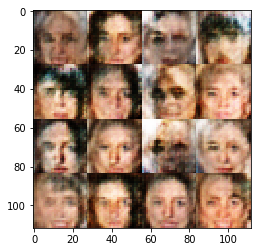

epoch 1/1 *** discriminator loss: 1.3025 *** generator loss: 1.0063
epoch 1/1 *** discriminator loss: 1.4923 *** generator loss: 0.7130
epoch 1/1 *** discriminator loss: 1.2641 *** generator loss: 0.8975
epoch 1/1 *** discriminator loss: 1.2868 *** generator loss: 0.8443
epoch 1/1 *** discriminator loss: 1.2652 *** generator loss: 0.8978
epoch 1/1 *** discriminator loss: 1.2693 *** generator loss: 0.8987
epoch 1/1 *** discriminator loss: 1.2293 *** generator loss: 1.1988
epoch 1/1 *** discriminator loss: 1.3268 *** generator loss: 1.0250
epoch 1/1 *** discriminator loss: 1.3738 *** generator loss: 1.0405
epoch 1/1 *** discriminator loss: 1.3387 *** generator loss: 0.8775


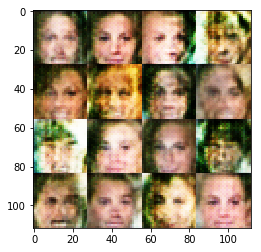

epoch 1/1 *** discriminator loss: 1.2782 *** generator loss: 0.8751
epoch 1/1 *** discriminator loss: 1.2258 *** generator loss: 0.8779
epoch 1/1 *** discriminator loss: 1.3267 *** generator loss: 0.8845
epoch 1/1 *** discriminator loss: 1.4167 *** generator loss: 0.6827
epoch 1/1 *** discriminator loss: 1.1785 *** generator loss: 0.9848
epoch 1/1 *** discriminator loss: 1.3922 *** generator loss: 0.7007
epoch 1/1 *** discriminator loss: 1.3062 *** generator loss: 0.8633
epoch 1/1 *** discriminator loss: 1.2177 *** generator loss: 0.8790
epoch 1/1 *** discriminator loss: 1.3020 *** generator loss: 1.0180
epoch 1/1 *** discriminator loss: 1.2517 *** generator loss: 1.0039


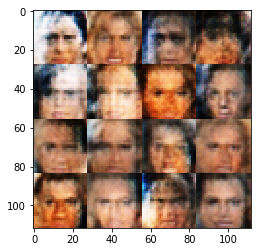

epoch 1/1 *** discriminator loss: 1.2871 *** generator loss: 0.9042
epoch 1/1 *** discriminator loss: 1.2898 *** generator loss: 0.9277
epoch 1/1 *** discriminator loss: 1.3451 *** generator loss: 0.8330
epoch 1/1 *** discriminator loss: 1.3688 *** generator loss: 1.0612
epoch 1/1 *** discriminator loss: 1.3790 *** generator loss: 1.1097
epoch 1/1 *** discriminator loss: 1.3698 *** generator loss: 0.8461
epoch 1/1 *** discriminator loss: 1.3046 *** generator loss: 0.8895
epoch 1/1 *** discriminator loss: 1.2585 *** generator loss: 0.9468
epoch 1/1 *** discriminator loss: 1.3077 *** generator loss: 0.8566
epoch 1/1 *** discriminator loss: 1.3843 *** generator loss: 0.8771


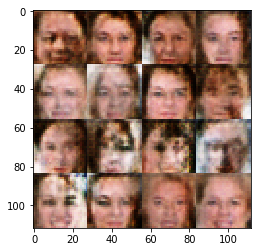

epoch 1/1 *** discriminator loss: 1.2798 *** generator loss: 0.9046
epoch 1/1 *** discriminator loss: 1.3270 *** generator loss: 0.9287
epoch 1/1 *** discriminator loss: 1.4137 *** generator loss: 0.8753
epoch 1/1 *** discriminator loss: 1.2566 *** generator loss: 0.9962
epoch 1/1 *** discriminator loss: 1.2290 *** generator loss: 1.1718
epoch 1/1 *** discriminator loss: 1.3319 *** generator loss: 0.9379
epoch 1/1 *** discriminator loss: 1.2967 *** generator loss: 0.8843
epoch 1/1 *** discriminator loss: 1.3193 *** generator loss: 0.8074
epoch 1/1 *** discriminator loss: 1.3217 *** generator loss: 0.8852
epoch 1/1 *** discriminator loss: 1.2919 *** generator loss: 0.8863


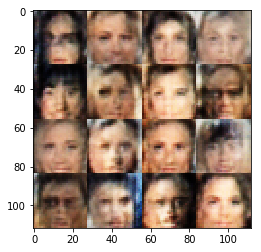

epoch 1/1 *** discriminator loss: 1.3646 *** generator loss: 0.8258
epoch 1/1 *** discriminator loss: 1.2716 *** generator loss: 0.9296
epoch 1/1 *** discriminator loss: 1.3300 *** generator loss: 0.8810
epoch 1/1 *** discriminator loss: 1.2924 *** generator loss: 0.8896
epoch 1/1 *** discriminator loss: 1.2643 *** generator loss: 1.0001
epoch 1/1 *** discriminator loss: 1.3950 *** generator loss: 0.7598
epoch 1/1 *** discriminator loss: 1.4139 *** generator loss: 0.8370
epoch 1/1 *** discriminator loss: 1.2691 *** generator loss: 0.8043
epoch 1/1 *** discriminator loss: 1.3266 *** generator loss: 0.8981
epoch 1/1 *** discriminator loss: 1.2412 *** generator loss: 0.8088


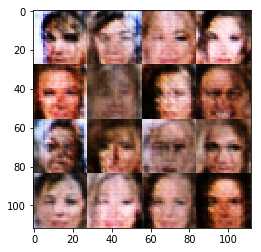

epoch 1/1 *** discriminator loss: 1.3748 *** generator loss: 0.8530
epoch 1/1 *** discriminator loss: 1.3346 *** generator loss: 0.9228
epoch 1/1 *** discriminator loss: 1.3681 *** generator loss: 0.8713
epoch 1/1 *** discriminator loss: 1.3186 *** generator loss: 0.8702
epoch 1/1 *** discriminator loss: 1.3412 *** generator loss: 0.9840
epoch 1/1 *** discriminator loss: 1.3737 *** generator loss: 1.0385
epoch 1/1 *** discriminator loss: 1.2995 *** generator loss: 0.7699
epoch 1/1 *** discriminator loss: 1.2830 *** generator loss: 1.0565
epoch 1/1 *** discriminator loss: 1.2515 *** generator loss: 0.9728
epoch 1/1 *** discriminator loss: 1.2337 *** generator loss: 1.0873


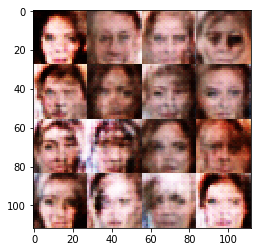

epoch 1/1 *** discriminator loss: 1.2673 *** generator loss: 0.9754
epoch 1/1 *** discriminator loss: 1.3579 *** generator loss: 0.8572
epoch 1/1 *** discriminator loss: 1.2813 *** generator loss: 1.0630
epoch 1/1 *** discriminator loss: 1.2178 *** generator loss: 1.0272
epoch 1/1 *** discriminator loss: 1.3300 *** generator loss: 0.9594
epoch 1/1 *** discriminator loss: 1.2789 *** generator loss: 0.9310
epoch 1/1 *** discriminator loss: 1.2505 *** generator loss: 0.8443
epoch 1/1 *** discriminator loss: 1.2385 *** generator loss: 0.9495
epoch 1/1 *** discriminator loss: 1.1748 *** generator loss: 0.9465
epoch 1/1 *** discriminator loss: 1.3009 *** generator loss: 0.9124


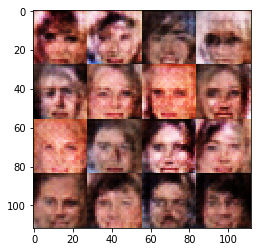

epoch 1/1 *** discriminator loss: 1.3185 *** generator loss: 0.8776
epoch 1/1 *** discriminator loss: 1.3323 *** generator loss: 1.0186
epoch 1/1 *** discriminator loss: 1.1677 *** generator loss: 1.0130
epoch 1/1 *** discriminator loss: 1.1938 *** generator loss: 1.0992
epoch 1/1 *** discriminator loss: 1.2661 *** generator loss: 0.9155
epoch 1/1 *** discriminator loss: 1.3513 *** generator loss: 1.0762
epoch 1/1 *** discriminator loss: 1.1215 *** generator loss: 1.2707
epoch 1/1 *** discriminator loss: 1.2546 *** generator loss: 0.8411
epoch 1/1 *** discriminator loss: 1.2285 *** generator loss: 0.9473
epoch 1/1 *** discriminator loss: 1.2258 *** generator loss: 0.8532


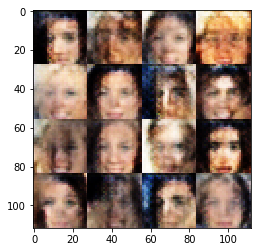

epoch 1/1 *** discriminator loss: 1.2142 *** generator loss: 1.2869
epoch 1/1 *** discriminator loss: 1.2247 *** generator loss: 0.9860
epoch 1/1 *** discriminator loss: 1.2810 *** generator loss: 1.1684
epoch 1/1 *** discriminator loss: 1.3140 *** generator loss: 0.9180
epoch 1/1 *** discriminator loss: 1.3520 *** generator loss: 0.9261
epoch 1/1 *** discriminator loss: 1.2979 *** generator loss: 1.0288
epoch 1/1 *** discriminator loss: 1.3707 *** generator loss: 0.8142
epoch 1/1 *** discriminator loss: 1.3460 *** generator loss: 0.7331
epoch 1/1 *** discriminator loss: 1.2871 *** generator loss: 0.9017
epoch 1/1 *** discriminator loss: 1.3348 *** generator loss: 0.9255


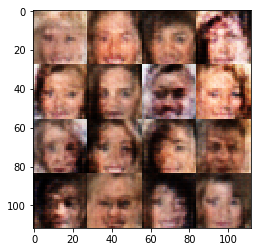

epoch 1/1 *** discriminator loss: 1.4339 *** generator loss: 0.7911
epoch 1/1 *** discriminator loss: 1.1700 *** generator loss: 0.9765
epoch 1/1 *** discriminator loss: 1.3605 *** generator loss: 0.7267
epoch 1/1 *** discriminator loss: 1.3789 *** generator loss: 0.6359
epoch 1/1 *** discriminator loss: 1.4502 *** generator loss: 0.7859
epoch 1/1 *** discriminator loss: 1.2836 *** generator loss: 0.9220
epoch 1/1 *** discriminator loss: 1.3468 *** generator loss: 0.8171
epoch 1/1 *** discriminator loss: 1.3854 *** generator loss: 0.7317
epoch 1/1 *** discriminator loss: 1.2815 *** generator loss: 0.8879
epoch 1/1 *** discriminator loss: 1.3577 *** generator loss: 0.9188


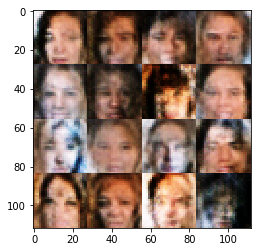

epoch 1/1 *** discriminator loss: 1.4714 *** generator loss: 0.8419
epoch 1/1 *** discriminator loss: 1.2239 *** generator loss: 0.8948
epoch 1/1 *** discriminator loss: 1.4199 *** generator loss: 0.8707
epoch 1/1 *** discriminator loss: 1.2560 *** generator loss: 1.0148
epoch 1/1 *** discriminator loss: 1.3235 *** generator loss: 0.7625
epoch 1/1 *** discriminator loss: 1.3969 *** generator loss: 0.9341
epoch 1/1 *** discriminator loss: 1.4025 *** generator loss: 0.9896
epoch 1/1 *** discriminator loss: 1.1734 *** generator loss: 1.0777
epoch 1/1 *** discriminator loss: 1.3894 *** generator loss: 0.8930
epoch 1/1 *** discriminator loss: 1.2856 *** generator loss: 0.9270


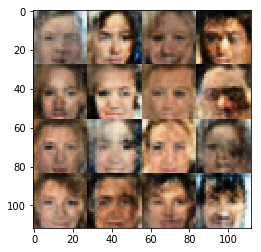

epoch 1/1 *** discriminator loss: 1.2313 *** generator loss: 0.9097
epoch 1/1 *** discriminator loss: 1.2682 *** generator loss: 0.8976
epoch 1/1 *** discriminator loss: 1.2295 *** generator loss: 0.9133
epoch 1/1 *** discriminator loss: 1.4460 *** generator loss: 0.6557
epoch 1/1 *** discriminator loss: 1.2696 *** generator loss: 0.9899
epoch 1/1 *** discriminator loss: 1.3227 *** generator loss: 0.8569
epoch 1/1 *** discriminator loss: 1.2916 *** generator loss: 0.9322
epoch 1/1 *** discriminator loss: 1.3292 *** generator loss: 1.0305
epoch 1/1 *** discriminator loss: 1.3535 *** generator loss: 0.7639
epoch 1/1 *** discriminator loss: 1.3058 *** generator loss: 0.8806


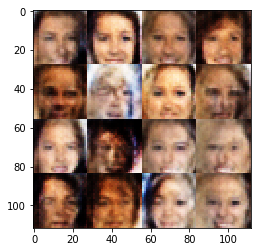

epoch 1/1 *** discriminator loss: 1.3417 *** generator loss: 0.9665
epoch 1/1 *** discriminator loss: 1.2876 *** generator loss: 0.8906
epoch 1/1 *** discriminator loss: 1.2385 *** generator loss: 0.9985
epoch 1/1 *** discriminator loss: 1.2444 *** generator loss: 0.9648
epoch 1/1 *** discriminator loss: 1.4073 *** generator loss: 0.6757
epoch 1/1 *** discriminator loss: 1.2790 *** generator loss: 0.9024
epoch 1/1 *** discriminator loss: 1.2620 *** generator loss: 0.9136
epoch 1/1 *** discriminator loss: 1.3292 *** generator loss: 0.7021
epoch 1/1 *** discriminator loss: 1.3281 *** generator loss: 0.8413
epoch 1/1 *** discriminator loss: 1.3682 *** generator loss: 0.8360


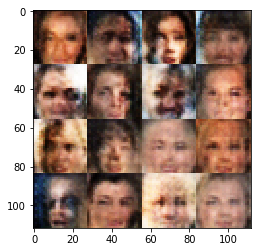

epoch 1/1 *** discriminator loss: 1.2576 *** generator loss: 0.9377
epoch 1/1 *** discriminator loss: 1.2793 *** generator loss: 0.8896
epoch 1/1 *** discriminator loss: 1.2747 *** generator loss: 0.8811
epoch 1/1 *** discriminator loss: 1.3242 *** generator loss: 0.8987
epoch 1/1 *** discriminator loss: 1.2424 *** generator loss: 0.9681
epoch 1/1 *** discriminator loss: 1.3005 *** generator loss: 0.9476
epoch 1/1 *** discriminator loss: 1.3497 *** generator loss: 0.7737
epoch 1/1 *** discriminator loss: 1.1924 *** generator loss: 0.9637
epoch 1/1 *** discriminator loss: 1.2602 *** generator loss: 0.9100
epoch 1/1 *** discriminator loss: 1.4178 *** generator loss: 0.7786


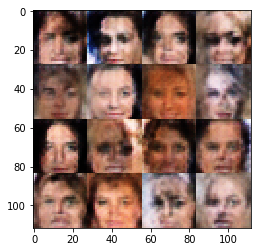

epoch 1/1 *** discriminator loss: 1.3049 *** generator loss: 0.9432
epoch 1/1 *** discriminator loss: 1.3609 *** generator loss: 0.7340
epoch 1/1 *** discriminator loss: 1.2760 *** generator loss: 1.0087
epoch 1/1 *** discriminator loss: 1.2775 *** generator loss: 0.8745
epoch 1/1 *** discriminator loss: 1.3087 *** generator loss: 0.8896
epoch 1/1 *** discriminator loss: 1.4354 *** generator loss: 1.0422
epoch 1/1 *** discriminator loss: 1.3676 *** generator loss: 0.8262
epoch 1/1 *** discriminator loss: 1.2638 *** generator loss: 0.9287
epoch 1/1 *** discriminator loss: 1.3375 *** generator loss: 0.7559
epoch 1/1 *** discriminator loss: 1.3070 *** generator loss: 0.9919


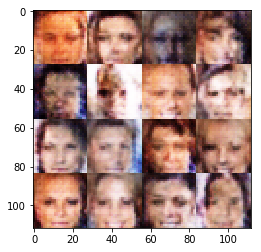

epoch 1/1 *** discriminator loss: 1.2628 *** generator loss: 0.9501
epoch 1/1 *** discriminator loss: 1.2905 *** generator loss: 0.9053
epoch 1/1 *** discriminator loss: 1.2957 *** generator loss: 1.0055
epoch 1/1 *** discriminator loss: 1.2562 *** generator loss: 0.9719
epoch 1/1 *** discriminator loss: 1.2754 *** generator loss: 0.9242
epoch 1/1 *** discriminator loss: 1.3352 *** generator loss: 0.8270
epoch 1/1 *** discriminator loss: 1.4653 *** generator loss: 0.7668
epoch 1/1 *** discriminator loss: 1.2274 *** generator loss: 1.0407
epoch 1/1 *** discriminator loss: 1.1480 *** generator loss: 1.0375
epoch 1/1 *** discriminator loss: 1.2425 *** generator loss: 0.8200


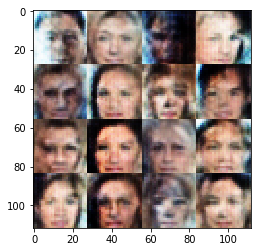

epoch 1/1 *** discriminator loss: 1.2768 *** generator loss: 0.9124
epoch 1/1 *** discriminator loss: 1.2508 *** generator loss: 0.8408
epoch 1/1 *** discriminator loss: 1.2939 *** generator loss: 0.9245
epoch 1/1 *** discriminator loss: 1.1806 *** generator loss: 1.1203
epoch 1/1 *** discriminator loss: 1.3450 *** generator loss: 0.7083
epoch 1/1 *** discriminator loss: 1.3711 *** generator loss: 0.8502
epoch 1/1 *** discriminator loss: 1.3564 *** generator loss: 0.8546
epoch 1/1 *** discriminator loss: 1.2998 *** generator loss: 0.9726
epoch 1/1 *** discriminator loss: 1.2396 *** generator loss: 1.0381
epoch 1/1 *** discriminator loss: 1.2258 *** generator loss: 0.9551


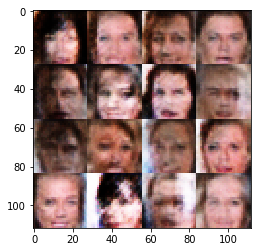

epoch 1/1 *** discriminator loss: 1.1780 *** generator loss: 1.0187
epoch 1/1 *** discriminator loss: 1.2873 *** generator loss: 1.0168
epoch 1/1 *** discriminator loss: 1.3651 *** generator loss: 0.8124


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.00035
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.